## Data Prep

**Import necessary modules and the ASOS/SNOTEL dataframes**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dtb
import os
from glob import glob
import datetime as dt
import seaborn as sns
pd.show_versions()


INSTALLED VERSIONS
------------------
commit: None
python: 3.6.5.final.0
python-bits: 32
OS: Windows
OS-release: 10
machine: AMD64
processor: Intel64 Family 6 Model 142 Stepping 9, GenuineIntel
byteorder: little
LC_ALL: None
LANG: en_US.UTF-8
LOCALE: None.None

pandas: 0.24.0
pytest: None
pip: 18.1
setuptools: 39.0.1
Cython: None
numpy: 1.14.3
scipy: 1.1.0
pyarrow: None
xarray: None
IPython: 6.4.0
sphinx: None
patsy: 0.5.1
dateutil: 2.7.3
pytz: 2018.4
blosc: None
bottleneck: None
tables: None
numexpr: None
feather: None
matplotlib: 2.2.2
openpyxl: None
xlrd: 1.2.0
xlwt: None
xlsxwriter: None
lxml.etree: 4.2.5
bs4: None
html5lib: 1.0.1
sqlalchemy: None
pymysql: None
psycopg2: None
jinja2: 2.10
s3fs: None
fastparquet: None
pandas_gbq: None
pandas_datareader: None
gcsfs: None


In [2]:
data = [pd.read_csv('asos_snotel_UA_12hr_df.dat', parse_dates = True, index_col = 'Date_Time')]
asos_snotel_UA_df = pd.concat(data)
#asos_snotel_UA_df['LXV_WindSpeed_m/s']

#asos_snotel_UA_df.rename(columns={'LXV_WindSpeed_m/s': 'LXV_WindSpeed_mps'}, inplace=True)

asos_snotel_UA_df.astype('float16')
pd.set_option('display.expand_frame_repr', True)


print(asos_snotel_UA_df.keys())




#delete empty columns as they mess up loops
#del asos_snotel_UA_df['CMtn_6hr_Precipitation_mm']            #empty column


Index(['CMtnSNTL_Temp_degC', 'CMtnSNTL_SnowDepth_in', 'CMtn_Temperature_degC',
       'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps',
       'CMtn_CloudCover_oktas', 'CMtn_1hr_Precipitation_mm',
       'LXV_Temperature_degC', 'LXV_Dewpoint_degC',
       ...
       'KGJT_d300_200_height_m', 'KGJT_d300_200_tmpc', 'KGJT_d300_200_dwpc',
       'KGJT_d300_200_drct', 'KGJT_d300_200_speed_kts',
       'KGJT_d250_200_height_m', 'KGJT_d250_200_tmpc', 'KGJT_d250_200_dwpc',
       'KGJT_d250_200_drct', 'KGJT_d250_200_speed_kts'],
      dtype='object', length=163)


In [3]:
all_yrs = (asos_snotel_UA_df.index >= '01-01-2006') & (asos_snotel_UA_df.index < '01-01-2018')
train_yrs = ((asos_snotel_UA_df.index >= '01-01-2006') & (asos_snotel_UA_df.index < '01-01-2013')) | ((asos_snotel_UA_df.index >= '01-01-2015') & (asos_snotel_UA_df.index < '01-01-2018'))
test_yrs = (asos_snotel_UA_df.index >= '01-01-2013') & (asos_snotel_UA_df.index < '01-01-2015')

test = (asos_snotel_UA_df.index >= '01-01-2006') & (asos_snotel_UA_df.index < '01-02-2006')
print(asos_snotel_UA_df['KGJT_d300_200_height_m'][test])

Date_Time
2006-01-01 00:00:00+00:00   -2630.0
2006-01-01 12:00:00+00:00   -2700.0
Name: KGJT_d300_200_height_m, dtype: float64


It is important to keep in mind that 'CMtnSNTL_12hr_SNWD_in contains snow depth info taken at the start of the respective 12hr period timestamp.  The snowfall calculated also gives the snowfall that fell in the 12hrs after the timestamp.  The OLS model will utilize hourly meteorological measurements at exactly 00:00 and 12:00 hours to predict the amount of snow which will fall in the next 12 hour period.  For example, the 00:00 meteorological measurements will be used to predict the snow which fell between 00:00 and 12:00.

***
# OLS Analysis of meteorological variables and snowfall (Training Dataset: 2007-2016 only)

**We will first utilize just the Copper Mountain surface level variables and run the model explicitly to generate statistics.  This will give snowfall predictive capability of individual meteorological variables (Dewpoint, SNOTEL Temperature, Temperature, Wind Speed, Cloud Cover, Wind Direction, 6hr Pressure change, and Pressure) using an OLS model and the 2008-2017 training dataset. The resulting values will also be used to verify some code which performs same analysis, but with a loop.  This code will then be fed all upper air and surface level variables to determine best combination of variables in the OLS model.**


In [4]:
#Import statsmodel

import statsmodels.api as sm
#import statsmodel
from statsmodels.formula.api import ols

### Single Variable OLS (CMtn Surface Variables)


#### Single Variable Summary
**Adjusted R:**  
OLS_CMtn_Dewpoint: 0.007  
OLS_CMtnSNTL_Temp:  -0.002 
OLS_CMtn_Temperature: -0.005  
OLS_CMtn_WindSpeed:  0.017  
OLS_CMtn_CloudCover:  0.000  
OLS_CMtn_WindDirection:  -0.004  
OLS_LXV_6hr_delta_Pressure:   0.004  
OLS_LXV_Pressure:    -0.003  

**Prob (F-statistic):**  
OLS_CMtn_Dewpoint: 0.139  
OLS_CMtnSNTL_Temp: 0.483  
OLS_CMtn_Temperature:  0.708  
OLS_CMtn_WindSpeed:  0.0466  
OLS_CMtn_CloudCover: 0.316 
OLS_CMtn_WindDirection:   0.614  
OLS_LXV_6hr_delta_Pressure:  0.155  
OLS_LXV_Pressure:   0.550 
  
From this, we can glean that Dewpoint alone likely has the best fit as the adjusted R squared is the highest.  The F statistics such signficant correlations (at 5% confident interval) for only  Dewpoint and Pressure).

## Determine which columns to use in OLS model.   
### Only going to to keep those data columns which have a matching hour to at least 67% of the snowfall measurements

In [5]:
variables = ['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'CMtn_CloudCover_oktas', \
 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_CloudCover_oktas', 'LXV_12hr_delta_Pressure_hp', \
 'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_drct', 'KGJT_200mb_speed_kts', \
 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc', 'KGJT_250mb_drct', 'KGJT_250mb_speed_kts', \
 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_drct', 'KGJT_300mb_speed_kts', \
 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_drct', 'KGJT_400mb_speed_kts', \
 'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_drct', 'KGJT_500mb_speed_kts', \
 'KGJT_700mb_height_m', 'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_drct', 'KGJT_700mb_speed_kts', \
 'KGJT_850mb_height_m', 'KGJT_850mb_tmpc', 'KGJT_850mb_dwpc', 'KGJT_850mb_drct', 'KGJT_850mb_speed_kts', \
 'KGJT_d850_700_height_m', 'KGJT_d850_700_tmpc', 'KGJT_d850_700_dwpc', 'KGJT_d850_700_drct', 'KGJT_d850_700_speed_kts', \
 'KGJT_d850_500_height_m', 'KGJT_d850_500_tmpc', 'KGJT_d850_500_dwpc', 'KGJT_d850_500_drct', 'KGJT_d850_500_speed_kts', \
 'KGJT_d850_400_height_m', 'KGJT_d850_400_tmpc', 'KGJT_d850_400_dwpc', 'KGJT_d850_400_drct', 'KGJT_d850_400_speed_kts', \
 'KGJT_d850_300_height_m', 'KGJT_d850_300_tmpc', 'KGJT_d850_300_dwpc', 'KGJT_d850_300_drct', 'KGJT_d850_300_speed_kts', \
 'KGJT_d850_250_height_m', 'KGJT_d850_250_tmpc', 'KGJT_d850_250_dwpc', 'KGJT_d850_250_drct', 'KGJT_d850_250_speed_kts', \
 'KGJT_d850_200_height_m', 'KGJT_d850_200_tmpc', 'KGJT_d850_200_dwpc', 'KGJT_d850_200_drct', 'KGJT_d850_200_speed_kts',\
 'KGJT_d700_500_height_m', 'KGJT_d700_500_tmpc', 'KGJT_d700_500_dwpc', 'KGJT_d700_500_drct', 'KGJT_d700_500_speed_kts', \
 'KGJT_d700_400_height_m', 'KGJT_d700_400_tmpc', 'KGJT_d700_400_dwpc', 'KGJT_d700_400_drct', 'KGJT_d700_400_speed_kts', \
 'KGJT_d700_300_height_m', 'KGJT_d700_300_tmpc', 'KGJT_d700_300_dwpc', 'KGJT_d700_300_drct', 'KGJT_d700_300_speed_kts', \
 'KGJT_d700_250_height_m', 'KGJT_d700_250_tmpc', 'KGJT_d700_250_dwpc', 'KGJT_d700_250_drct', 'KGJT_d700_250_speed_kts', \
 'KGJT_d700_200_height_m', 'KGJT_d700_200_tmpc', 'KGJT_d700_200_dwpc', 'KGJT_d700_200_drct', 'KGJT_d700_200_speed_kts', \
 'KGJT_d500_400_height_m', 'KGJT_d500_400_tmpc', 'KGJT_d500_400_dwpc', 'KGJT_d500_400_drct', 'KGJT_d500_400_speed_kts', \
 'KGJT_d500_300_height_m', 'KGJT_d500_300_tmpc', 'KGJT_d500_300_dwpc', 'KGJT_d500_300_drct', 'KGJT_d500_300_speed_kts', \
 'KGJT_d500_250_height_m', 'KGJT_d500_250_tmpc', 'KGJT_d500_250_dwpc', 'KGJT_d500_250_drct', 'KGJT_d500_250_speed_kts', \
 'KGJT_d500_200_height_m', 'KGJT_d500_200_tmpc', 'KGJT_d500_200_dwpc', 'KGJT_d500_200_drct', 'KGJT_d500_200_speed_kts', \
 'KGJT_d400_300_height_m', 'KGJT_d400_300_tmpc', 'KGJT_d400_300_dwpc', 'KGJT_d400_300_drct', 'KGJT_d400_300_speed_kts', \
 'KGJT_d400_250_height_m', 'KGJT_d400_250_tmpc', 'KGJT_d400_250_dwpc', 'KGJT_d400_250_drct', 'KGJT_d400_250_speed_kts', \
 'KGJT_d400_200_height_m', 'KGJT_d400_200_tmpc', 'KGJT_d400_200_dwpc', 'KGJT_d400_200_drct', 'KGJT_d400_200_speed_kts', \
 'KGJT_d300_250_height_m', 'KGJT_d300_250_tmpc', 'KGJT_d300_250_dwpc', 'KGJT_d300_250_drct', 'KGJT_d300_250_speed_kts', \
 'KGJT_d300_200_height_m', 'KGJT_d300_200_tmpc', 'KGJT_d300_200_dwpc', 'KGJT_d300_200_drct', 'KGJT_d300_200_speed_kts', \
 'KGJT_d250_200_height_m', 'KGJT_d250_200_tmpc', 'KGJT_d250_200_dwpc', 'KGJT_d250_200_drct', 'KGJT_d250_200_speed_kts']

good_vars = []
bad_vars = []
for var in variables:
    idx = np.isfinite(asos_snotel_UA_df[all_yrs]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']) & np.isfinite(asos_snotel_UA_df[all_yrs][var])
 #   total_poss = len(asos_snotel_UA_df[all_yrs]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][asos_snotel_UA_df[all_yrs]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']>=0])
    
    total_poss = asos_snotel_UA_df[all_yrs]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'].count()   #counts only non missing values
    total_avail =len(asos_snotel_UA_df[all_yrs][idx]) 
    
    if total_avail/total_poss >= 0.67: 
        good_vars.append(var)
    else:
        bad_vars.append(var)
        


        
print('Variables with >= 67% data match to snowfall: ')
print(good_vars)
print('Variables with < 67% data match to snowfall: ')
print(bad_vars)
    



Variables with >= 67% data match to snowfall: 
['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_12hr_delta_Pressure_hp', 'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_drct', 'KGJT_200mb_speed_kts', 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc', 'KGJT_250mb_drct', 'KGJT_250mb_speed_kts', 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_drct', 'KGJT_300mb_speed_kts', 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_drct', 'KGJT_400mb_speed_kts', 'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_drct', 'KGJT_500mb_speed_kts', 'KGJT_700mb_height_m', 'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_drct', 'KGJT_700mb_speed_kts', 'KGJT_850mb_height_m', 'KGJT_d850_700_height_m', 'KGJT_d850_500_height_

In [6]:
good_vars_snf =[]
filtered_asos_snotel_UA_df = pd.DataFrame()


#df_sfc = asos_snotel_UA_df[['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', \
#                           'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_12hr_delta_Pressure_hp','CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']].copy()
#
#df = asos_snotel_UA_df[df = asos_snotel_UA_df[['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', \
#                        'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_12hr_delta_Pressure_hp', \
#                        'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_drct', 'KGJT_200mb_speed_kts', 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', \
#                        'KGJT_250mb_dwpc', 'KGJT_250mb_drct', 'KGJT_250mb_speed_kts', 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_drct', \
#                        'KGJT_300mb_speed_kts', 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_drct', 'KGJT_400mb_speed_kts', \
#                        'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_drct', 'KGJT_500mb_speed_kts', 'KGJT_700mb_height_m', \
#                        'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_drct', 'KGJT_700mb_speed_kts', 'KGJT_850mb_height_m', 'KGJT_d850_700_height_m', \
#                        'KGJT_d850_500_height_m', 'KGJT_d850_400_height_m', 'KGJT_d850_300_height_m', 'KGJT_d850_250_height_m', 'KGJT_d850_200_height_m', 'KGJT_d700_500_height_m', 'KGJT_d700_500_tmpc', 'KGJT_d700_500_dwpc', 'KGJT_d700_500_drct', 'KGJT_d700_500_speed_kts', 'KGJT_d700_400_height_m', 'KGJT_d700_400_tmpc', 'KGJT_d700_400_dwpc', 'KGJT_d700_400_drct', 'KGJT_d700_400_speed_kts', 'KGJT_d700_300_height_m', 'KGJT_d700_300_tmpc', 'KGJT_d700_300_dwpc', 'KGJT_d700_300_drct', 'KGJT_d700_300_speed_kts', 'KGJT_d700_250_height_m', 'KGJT_d700_250_tmpc', 'KGJT_d700_250_dwpc', 'KGJT_d700_250_drct', 'KGJT_d700_250_speed_kts', 'KGJT_d700_200_height_m', 'KGJT_d700_200_tmpc', 'KGJT_d700_200_dwpc', 'KGJT_d700_200_drct', 'KGJT_d700_200_speed_kts', 'KGJT_d500_400_height_m', 'KGJT_d500_400_tmpc', 'KGJT_d500_400_dwpc', 'KGJT_d500_400_drct', 'KGJT_d500_400_speed_kts', 'KGJT_d500_300_height_m', 'KGJT_d500_300_tmpc', 'KGJT_d500_300_dwpc', 'KGJT_d500_300_drct', 'KGJT_d500_300_speed_kts', 'KGJT_d500_250_height_m', 'KGJT_d500_250_tmpc', 'KGJT_d500_250_dwpc', 'KGJT_d500_250_drct', 'KGJT_d500_250_speed_kts', 'KGJT_d500_200_height_m', 'KGJT_d500_200_tmpc', 'KGJT_d500_200_dwpc', 'KGJT_d500_200_drct', 'KGJT_d500_200_speed_kts', 'KGJT_d400_300_height_m', 'KGJT_d400_300_tmpc', 'KGJT_d400_300_dwpc', 'KGJT_d400_300_drct', 'KGJT_d400_300_speed_kts', 'KGJT_d400_250_height_m', 'KGJT_d400_250_tmpc', 'KGJT_d400_250_dwpc', 'KGJT_d400_250_drct', 'KGJT_d400_250_speed_kts', 'KGJT_d400_200_height_m', 'KGJT_d400_200_tmpc', 'KGJT_d400_200_dwpc', 'KGJT_d400_200_drct', 'KGJT_d400_200_speed_kts', 'KGJT_d300_250_height_m', 'KGJT_d300_250_tmpc', 'KGJT_d300_250_dwpc', 'KGJT_d300_250_drct', 'KGJT_d300_250_speed_kts', 'KGJT_d300_200_height_m', 'KGJT_d300_200_tmpc', 'KGJT_d300_200_dwpc', 'KGJT_d300_200_drct', 'KGJT_d300_200_speed_kts', \
#                        'KGJT_d250_200_height_m', 'KGJT_d250_200_tmpc', 'KGJT_d250_200_dwpc', 'KGJT_d250_200_drct', \
#                         'KGJT_d250_200_speed_kts','CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']].copy()

good_vars_snf = good_vars + ['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']
print(good_vars_snf )
filtered_asos_snotel_UA_df=  asos_snotel_UA_df[good_vars_snf].copy()
test_train_df = asos_snotel_UA_df[good_vars_snf].dropna()

print(test_train_df)

['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_12hr_delta_Pressure_hp', 'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_drct', 'KGJT_200mb_speed_kts', 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc', 'KGJT_250mb_drct', 'KGJT_250mb_speed_kts', 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_drct', 'KGJT_300mb_speed_kts', 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_drct', 'KGJT_400mb_speed_kts', 'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_drct', 'KGJT_500mb_speed_kts', 'KGJT_700mb_height_m', 'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_drct', 'KGJT_700mb_speed_kts', 'KGJT_850mb_height_m', 'KGJT_d850_700_height_m', 'KGJT_d850_500_height_m', 'KGJT_d850_400_height_m', 'KGJT_d850_300_he

In [7]:
import statistics as sts
all_yrs_tt = (test_train_df.index >= '01-01-2006') & (test_train_df.index < '01-01-2018')
train_yrs_tt=  ((test_train_df.index >= '01-01-2006') & (test_train_df.index < '01-01-2013')) | ((test_train_df.index >= '01-01-2015') & (test_train_df.index < '01-01-2018'))
test_yrs_tt = (test_train_df.index >= '01-01-2013') & (test_train_df.index < '01-01-2015')



### Now run OLS model with the chosen variables ##

In [8]:
from collections import OrderedDict

variables = good_vars
variables_org = variables
print(variables)

print('******')
adjRs = []
newRs = []
dup_var = []
max_vars = []
f_pvalues = []

while variables != []:
  #print(variables)
  for var in variables:
        
    #print(variables)
    max_var = max(variables, key = lambda v: ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + v, test_train_df[train_yrs_tt]).fit().rsquared_adj)    #this finds OLS model run with highest adj R squared
    OLS = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + max_var, test_train_df[train_yrs_tt]).fit()
    print(max_var)
    print(OLS.rsquared_adj)
    
    #Create lists of statistics for each combination of variables modeld
    adjRs.append(OLS.rsquared_adj)
    f_pvalues.append(OLS.f_pvalue)
    max_vars.append(max_var)

    add_max_var = '+ '+ max_var
    
    variables = [s + add_max_var for s in variables_org]
    
    #The above for loop naturally will create a duplicate variable, which should be removed
    for v in variables_org: 
      dup_var = []
      dup_var = [var for var in variables if var.count(v)>1]
      if dup_var!=[]:
            for dup in dup_var: variables.remove(dup)

#combine the modeled variable sequences with respective stats  
stats = list(zip(adjRs, f_pvalues))    # create list of tuples
dictionary = OrderedDict(zip(max_vars, stats))
#dictionary_adjRs = OrderedDict(zip(max_vars, f_pvalues))
print(adjRs)
print(max_vars)
print(f_pvalues)
print(dictionary)



['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_12hr_delta_Pressure_hp', 'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_drct', 'KGJT_200mb_speed_kts', 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc', 'KGJT_250mb_drct', 'KGJT_250mb_speed_kts', 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_drct', 'KGJT_300mb_speed_kts', 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_drct', 'KGJT_400mb_speed_kts', 'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_drct', 'KGJT_500mb_speed_kts', 'KGJT_700mb_height_m', 'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_drct', 'KGJT_700mb_speed_kts', 'KGJT_850mb_height_m', 'KGJT_d850_700_height_m', 'KGJT_d850_500_height_m', 'KGJT_d850_400_height_m', 'KGJT_d850_300_he

KGJT_d500_250_height_m+ KGJT_200mb_height_m+ LXV_Pressure_hp+ KGJT_300mb_dwpc+ KGJT_d700_400_height_m+ KGJT_500mb_tmpc+ KGJT_d300_250_tmpc+ KGJT_d850_200_height_m+ KGJT_d400_300_height_m+ KGJT_d700_250_dwpc+ LXV_WindDirection_deg+ KGJT_d500_250_drct+ KGJT_300mb_speed_kts+ KGJT_d250_200_dwpc+ KGJT_d700_400_speed_kts+ CMtnSNTL_Temp_degC+ KGJT_d700_400_tmpc+ KGJT_d250_200_tmpc+ CMtn_WindDirection_deg+ KGJT_d300_250_drct+ KGJT_250mb_speed_kts+ KGJT_d700_500_drct+ CMtn_Dewpoint_degC
0.29717718563111906
LXV_WindSpeed_mps+ KGJT_d500_250_height_m+ KGJT_200mb_height_m+ LXV_Pressure_hp+ KGJT_300mb_dwpc+ KGJT_d700_400_height_m+ KGJT_500mb_tmpc+ KGJT_d300_250_tmpc+ KGJT_d850_200_height_m+ KGJT_d400_300_height_m+ KGJT_d700_250_dwpc+ LXV_WindDirection_deg+ KGJT_d500_250_drct+ KGJT_300mb_speed_kts+ KGJT_d250_200_dwpc+ KGJT_d700_400_speed_kts+ CMtnSNTL_Temp_degC+ KGJT_d700_400_tmpc+ KGJT_d250_200_tmpc+ CMtn_WindDirection_deg+ KGJT_d300_250_drct+ KGJT_250mb_speed_kts+ KGJT_d700_500_drct+ CMtn_Dewpoint_

KGJT_400mb_drct+ LXV_Temperature_degC+ KGJT_d500_400_dwpc+ KGJT_d300_200_tmpc+ KGJT_d700_200_dwpc+ KGJT_d300_250_speed_kts+ KGJT_850mb_height_m+ KGJT_d700_300_height_m+ KGJT_d700_300_drct+ KGJT_d500_300_drct+ KGJT_d700_250_drct+ KGJT_d500_200_speed_kts+ LXV_WindSpeed_mps+ KGJT_d500_250_height_m+ KGJT_200mb_height_m+ LXV_Pressure_hp+ KGJT_300mb_dwpc+ KGJT_d700_400_height_m+ KGJT_500mb_tmpc+ KGJT_d300_250_tmpc+ KGJT_d850_200_height_m+ KGJT_d400_300_height_m+ KGJT_d700_250_dwpc+ LXV_WindDirection_deg+ KGJT_d500_250_drct+ KGJT_300mb_speed_kts+ KGJT_d250_200_dwpc+ KGJT_d700_400_speed_kts+ CMtnSNTL_Temp_degC+ KGJT_d700_400_tmpc+ KGJT_d250_200_tmpc+ CMtn_WindDirection_deg+ KGJT_d300_250_drct+ KGJT_250mb_speed_kts+ KGJT_d700_500_drct+ CMtn_Dewpoint_degC
0.2929124731213585
KGJT_d300_200_speed_kts+ KGJT_400mb_drct+ LXV_Temperature_degC+ KGJT_d500_400_dwpc+ KGJT_d300_200_tmpc+ KGJT_d700_200_dwpc+ KGJT_d300_250_speed_kts+ KGJT_850mb_height_m+ KGJT_d700_300_height_m+ KGJT_d700_300_drct+ KGJT_d500_3

KGJT_500mb_height_m+ KGJT_d850_250_height_m+ KGJT_d500_200_height_m+ KGJT_250mb_height_m+ KGJT_d500_300_speed_kts+ KGJT_d250_200_speed_kts+ KGJT_500mb_speed_kts+ KGJT_200mb_speed_kts+ KGJT_d500_250_speed_kts+ KGJT_d300_200_speed_kts+ KGJT_400mb_drct+ LXV_Temperature_degC+ KGJT_d500_400_dwpc+ KGJT_d300_200_tmpc+ KGJT_d700_200_dwpc+ KGJT_d300_250_speed_kts+ KGJT_850mb_height_m+ KGJT_d700_300_height_m+ KGJT_d700_300_drct+ KGJT_d500_300_drct+ KGJT_d700_250_drct+ KGJT_d500_200_speed_kts+ LXV_WindSpeed_mps+ KGJT_d500_250_height_m+ KGJT_200mb_height_m+ LXV_Pressure_hp+ KGJT_300mb_dwpc+ KGJT_d700_400_height_m+ KGJT_500mb_tmpc+ KGJT_d300_250_tmpc+ KGJT_d850_200_height_m+ KGJT_d400_300_height_m+ KGJT_d700_250_dwpc+ LXV_WindDirection_deg+ KGJT_d500_250_drct+ KGJT_300mb_speed_kts+ KGJT_d250_200_dwpc+ KGJT_d700_400_speed_kts+ CMtnSNTL_Temp_degC+ KGJT_d700_400_tmpc+ KGJT_d250_200_tmpc+ CMtn_WindDirection_deg+ KGJT_d300_250_drct+ KGJT_250mb_speed_kts+ KGJT_d700_500_drct+ CMtn_Dewpoint_degC
0.28619191

KGJT_300mb_tmpc+ KGJT_d500_200_tmpc+ KGJT_200mb_tmpc+ KGJT_d500_250_tmpc+ KGJT_250mb_tmpc+ LXV_12hr_delta_Pressure_hp+ KGJT_d250_200_height_m+ KGJT_d850_500_height_m+ KGJT_500mb_height_m+ KGJT_d850_250_height_m+ KGJT_d500_200_height_m+ KGJT_250mb_height_m+ KGJT_d500_300_speed_kts+ KGJT_d250_200_speed_kts+ KGJT_500mb_speed_kts+ KGJT_200mb_speed_kts+ KGJT_d500_250_speed_kts+ KGJT_d300_200_speed_kts+ KGJT_400mb_drct+ LXV_Temperature_degC+ KGJT_d500_400_dwpc+ KGJT_d300_200_tmpc+ KGJT_d700_200_dwpc+ KGJT_d300_250_speed_kts+ KGJT_850mb_height_m+ KGJT_d700_300_height_m+ KGJT_d700_300_drct+ KGJT_d500_300_drct+ KGJT_d700_250_drct+ KGJT_d500_200_speed_kts+ LXV_WindSpeed_mps+ KGJT_d500_250_height_m+ KGJT_200mb_height_m+ LXV_Pressure_hp+ KGJT_300mb_dwpc+ KGJT_d700_400_height_m+ KGJT_500mb_tmpc+ KGJT_d300_250_tmpc+ KGJT_d850_200_height_m+ KGJT_d400_300_height_m+ KGJT_d700_250_dwpc+ LXV_WindDirection_deg+ KGJT_d500_250_drct+ KGJT_300mb_speed_kts+ KGJT_d250_200_dwpc+ KGJT_d700_400_speed_kts+ CMtnSNTL

KGJT_d700_250_tmpc+ KGJT_400mb_tmpc+ KGJT_d700_200_tmpc+ KGJT_d700_300_tmpc+ KGJT_d700_500_tmpc+ KGJT_d400_300_tmpc+ KGJT_d500_300_tmpc+ KGJT_300mb_tmpc+ KGJT_d500_200_tmpc+ KGJT_200mb_tmpc+ KGJT_d500_250_tmpc+ KGJT_250mb_tmpc+ LXV_12hr_delta_Pressure_hp+ KGJT_d250_200_height_m+ KGJT_d850_500_height_m+ KGJT_500mb_height_m+ KGJT_d850_250_height_m+ KGJT_d500_200_height_m+ KGJT_250mb_height_m+ KGJT_d500_300_speed_kts+ KGJT_d250_200_speed_kts+ KGJT_500mb_speed_kts+ KGJT_200mb_speed_kts+ KGJT_d500_250_speed_kts+ KGJT_d300_200_speed_kts+ KGJT_400mb_drct+ LXV_Temperature_degC+ KGJT_d500_400_dwpc+ KGJT_d300_200_tmpc+ KGJT_d700_200_dwpc+ KGJT_d300_250_speed_kts+ KGJT_850mb_height_m+ KGJT_d700_300_height_m+ KGJT_d700_300_drct+ KGJT_d500_300_drct+ KGJT_d700_250_drct+ KGJT_d500_200_speed_kts+ LXV_WindSpeed_mps+ KGJT_d500_250_height_m+ KGJT_200mb_height_m+ LXV_Pressure_hp+ KGJT_300mb_dwpc+ KGJT_d700_400_height_m+ KGJT_500mb_tmpc+ KGJT_d300_250_tmpc+ KGJT_d850_200_height_m+ KGJT_d400_300_height_m+ K

KGJT_250mb_dwpc+ KGJT_200mb_dwpc+ KGJT_d300_200_dwpc+ KGJT_d400_200_tmpc+ KGJT_d500_400_tmpc+ KGJT_700mb_tmpc+ KGJT_d400_250_tmpc+ KGJT_d700_250_tmpc+ KGJT_400mb_tmpc+ KGJT_d700_200_tmpc+ KGJT_d700_300_tmpc+ KGJT_d700_500_tmpc+ KGJT_d400_300_tmpc+ KGJT_d500_300_tmpc+ KGJT_300mb_tmpc+ KGJT_d500_200_tmpc+ KGJT_200mb_tmpc+ KGJT_d500_250_tmpc+ KGJT_250mb_tmpc+ LXV_12hr_delta_Pressure_hp+ KGJT_d250_200_height_m+ KGJT_d850_500_height_m+ KGJT_500mb_height_m+ KGJT_d850_250_height_m+ KGJT_d500_200_height_m+ KGJT_250mb_height_m+ KGJT_d500_300_speed_kts+ KGJT_d250_200_speed_kts+ KGJT_500mb_speed_kts+ KGJT_200mb_speed_kts+ KGJT_d500_250_speed_kts+ KGJT_d300_200_speed_kts+ KGJT_400mb_drct+ LXV_Temperature_degC+ KGJT_d500_400_dwpc+ KGJT_d300_200_tmpc+ KGJT_d700_200_dwpc+ KGJT_d300_250_speed_kts+ KGJT_850mb_height_m+ KGJT_d700_300_height_m+ KGJT_d700_300_drct+ KGJT_d500_300_drct+ KGJT_d700_250_drct+ KGJT_d500_200_speed_kts+ LXV_WindSpeed_mps+ KGJT_d500_250_height_m+ KGJT_200mb_height_m+ LXV_Pressure_

KGJT_d500_250_dwpc+ KGJT_d500_200_dwpc+ LXV_Dewpoint_degC+ KGJT_d300_250_dwpc+ KGJT_700mb_dwpc+ KGJT_d700_300_dwpc+ KGJT_250mb_dwpc+ KGJT_200mb_dwpc+ KGJT_d300_200_dwpc+ KGJT_d400_200_tmpc+ KGJT_d500_400_tmpc+ KGJT_700mb_tmpc+ KGJT_d400_250_tmpc+ KGJT_d700_250_tmpc+ KGJT_400mb_tmpc+ KGJT_d700_200_tmpc+ KGJT_d700_300_tmpc+ KGJT_d700_500_tmpc+ KGJT_d400_300_tmpc+ KGJT_d500_300_tmpc+ KGJT_300mb_tmpc+ KGJT_d500_200_tmpc+ KGJT_200mb_tmpc+ KGJT_d500_250_tmpc+ KGJT_250mb_tmpc+ LXV_12hr_delta_Pressure_hp+ KGJT_d250_200_height_m+ KGJT_d850_500_height_m+ KGJT_500mb_height_m+ KGJT_d850_250_height_m+ KGJT_d500_200_height_m+ KGJT_250mb_height_m+ KGJT_d500_300_speed_kts+ KGJT_d250_200_speed_kts+ KGJT_500mb_speed_kts+ KGJT_200mb_speed_kts+ KGJT_d500_250_speed_kts+ KGJT_d300_200_speed_kts+ KGJT_400mb_drct+ LXV_Temperature_degC+ KGJT_d500_400_dwpc+ KGJT_d300_200_tmpc+ KGJT_d700_200_dwpc+ KGJT_d300_250_speed_kts+ KGJT_850mb_height_m+ KGJT_d700_300_height_m+ KGJT_d700_300_drct+ KGJT_d500_300_drct+ KGJT_d

KGJT_d700_500_dwpc+ KGJT_d700_400_dwpc+ KGJT_d500_300_dwpc+ KGJT_d400_250_dwpc+ KGJT_400mb_dwpc+ KGJT_d400_200_dwpc+ KGJT_d500_250_dwpc+ KGJT_d500_200_dwpc+ LXV_Dewpoint_degC+ KGJT_d300_250_dwpc+ KGJT_700mb_dwpc+ KGJT_d700_300_dwpc+ KGJT_250mb_dwpc+ KGJT_200mb_dwpc+ KGJT_d300_200_dwpc+ KGJT_d400_200_tmpc+ KGJT_d500_400_tmpc+ KGJT_700mb_tmpc+ KGJT_d400_250_tmpc+ KGJT_d700_250_tmpc+ KGJT_400mb_tmpc+ KGJT_d700_200_tmpc+ KGJT_d700_300_tmpc+ KGJT_d700_500_tmpc+ KGJT_d400_300_tmpc+ KGJT_d500_300_tmpc+ KGJT_300mb_tmpc+ KGJT_d500_200_tmpc+ KGJT_200mb_tmpc+ KGJT_d500_250_tmpc+ KGJT_250mb_tmpc+ LXV_12hr_delta_Pressure_hp+ KGJT_d250_200_height_m+ KGJT_d850_500_height_m+ KGJT_500mb_height_m+ KGJT_d850_250_height_m+ KGJT_d500_200_height_m+ KGJT_250mb_height_m+ KGJT_d500_300_speed_kts+ KGJT_d250_200_speed_kts+ KGJT_500mb_speed_kts+ KGJT_200mb_speed_kts+ KGJT_d500_250_speed_kts+ KGJT_d300_200_speed_kts+ KGJT_400mb_drct+ LXV_Temperature_degC+ KGJT_d500_400_dwpc+ KGJT_d300_200_tmpc+ KGJT_d700_200_dwpc+

KGJT_250mb_drct+ KGJT_300mb_drct+ KGJT_500mb_drct+ KGJT_500mb_dwpc+ KGJT_d400_300_dwpc+ KGJT_d700_500_dwpc+ KGJT_d700_400_dwpc+ KGJT_d500_300_dwpc+ KGJT_d400_250_dwpc+ KGJT_400mb_dwpc+ KGJT_d400_200_dwpc+ KGJT_d500_250_dwpc+ KGJT_d500_200_dwpc+ LXV_Dewpoint_degC+ KGJT_d300_250_dwpc+ KGJT_700mb_dwpc+ KGJT_d700_300_dwpc+ KGJT_250mb_dwpc+ KGJT_200mb_dwpc+ KGJT_d300_200_dwpc+ KGJT_d400_200_tmpc+ KGJT_d500_400_tmpc+ KGJT_700mb_tmpc+ KGJT_d400_250_tmpc+ KGJT_d700_250_tmpc+ KGJT_400mb_tmpc+ KGJT_d700_200_tmpc+ KGJT_d700_300_tmpc+ KGJT_d700_500_tmpc+ KGJT_d400_300_tmpc+ KGJT_d500_300_tmpc+ KGJT_300mb_tmpc+ KGJT_d500_200_tmpc+ KGJT_200mb_tmpc+ KGJT_d500_250_tmpc+ KGJT_250mb_tmpc+ LXV_12hr_delta_Pressure_hp+ KGJT_d250_200_height_m+ KGJT_d850_500_height_m+ KGJT_500mb_height_m+ KGJT_d850_250_height_m+ KGJT_d500_200_height_m+ KGJT_250mb_height_m+ KGJT_d500_300_speed_kts+ KGJT_d250_200_speed_kts+ KGJT_500mb_speed_kts+ KGJT_200mb_speed_kts+ KGJT_d500_250_speed_kts+ KGJT_d300_200_speed_kts+ KGJT_400mb

KGJT_d500_400_drct+ KGJT_d700_400_drct+ KGJT_d400_250_drct+ KGJT_700mb_drct+ KGJT_d400_300_drct+ KGJT_250mb_drct+ KGJT_300mb_drct+ KGJT_500mb_drct+ KGJT_500mb_dwpc+ KGJT_d400_300_dwpc+ KGJT_d700_500_dwpc+ KGJT_d700_400_dwpc+ KGJT_d500_300_dwpc+ KGJT_d400_250_dwpc+ KGJT_400mb_dwpc+ KGJT_d400_200_dwpc+ KGJT_d500_250_dwpc+ KGJT_d500_200_dwpc+ LXV_Dewpoint_degC+ KGJT_d300_250_dwpc+ KGJT_700mb_dwpc+ KGJT_d700_300_dwpc+ KGJT_250mb_dwpc+ KGJT_200mb_dwpc+ KGJT_d300_200_dwpc+ KGJT_d400_200_tmpc+ KGJT_d500_400_tmpc+ KGJT_700mb_tmpc+ KGJT_d400_250_tmpc+ KGJT_d700_250_tmpc+ KGJT_400mb_tmpc+ KGJT_d700_200_tmpc+ KGJT_d700_300_tmpc+ KGJT_d700_500_tmpc+ KGJT_d400_300_tmpc+ KGJT_d500_300_tmpc+ KGJT_300mb_tmpc+ KGJT_d500_200_tmpc+ KGJT_200mb_tmpc+ KGJT_d500_250_tmpc+ KGJT_250mb_tmpc+ LXV_12hr_delta_Pressure_hp+ KGJT_d250_200_height_m+ KGJT_d850_500_height_m+ KGJT_500mb_height_m+ KGJT_d850_250_height_m+ KGJT_d500_200_height_m+ KGJT_250mb_height_m+ KGJT_d500_300_speed_kts+ KGJT_d250_200_speed_kts+ KGJT_50

KGJT_d500_300_height_m+ KGJT_d500_400_height_m+ KGJT_d850_300_height_m+ KGJT_400mb_height_m+ KGJT_300mb_height_m+ KGJT_d500_400_drct+ KGJT_d700_400_drct+ KGJT_d400_250_drct+ KGJT_700mb_drct+ KGJT_d400_300_drct+ KGJT_250mb_drct+ KGJT_300mb_drct+ KGJT_500mb_drct+ KGJT_500mb_dwpc+ KGJT_d400_300_dwpc+ KGJT_d700_500_dwpc+ KGJT_d700_400_dwpc+ KGJT_d500_300_dwpc+ KGJT_d400_250_dwpc+ KGJT_400mb_dwpc+ KGJT_d400_200_dwpc+ KGJT_d500_250_dwpc+ KGJT_d500_200_dwpc+ LXV_Dewpoint_degC+ KGJT_d300_250_dwpc+ KGJT_700mb_dwpc+ KGJT_d700_300_dwpc+ KGJT_250mb_dwpc+ KGJT_200mb_dwpc+ KGJT_d300_200_dwpc+ KGJT_d400_200_tmpc+ KGJT_d500_400_tmpc+ KGJT_700mb_tmpc+ KGJT_d400_250_tmpc+ KGJT_d700_250_tmpc+ KGJT_400mb_tmpc+ KGJT_d700_200_tmpc+ KGJT_d700_300_tmpc+ KGJT_d700_500_tmpc+ KGJT_d400_300_tmpc+ KGJT_d500_300_tmpc+ KGJT_300mb_tmpc+ KGJT_d500_200_tmpc+ KGJT_200mb_tmpc+ KGJT_d500_250_tmpc+ KGJT_250mb_tmpc+ LXV_12hr_delta_Pressure_hp+ KGJT_d250_200_height_m+ KGJT_d850_500_height_m+ KGJT_500mb_height_m+ KGJT_d850_25

KGJT_d400_200_height_m+ KGJT_d300_250_height_m+ KGJT_d850_700_height_m+ KGJT_d400_250_height_m+ KGJT_700mb_height_m+ KGJT_d500_300_height_m+ KGJT_d500_400_height_m+ KGJT_d850_300_height_m+ KGJT_400mb_height_m+ KGJT_300mb_height_m+ KGJT_d500_400_drct+ KGJT_d700_400_drct+ KGJT_d400_250_drct+ KGJT_700mb_drct+ KGJT_d400_300_drct+ KGJT_250mb_drct+ KGJT_300mb_drct+ KGJT_500mb_drct+ KGJT_500mb_dwpc+ KGJT_d400_300_dwpc+ KGJT_d700_500_dwpc+ KGJT_d700_400_dwpc+ KGJT_d500_300_dwpc+ KGJT_d400_250_dwpc+ KGJT_400mb_dwpc+ KGJT_d400_200_dwpc+ KGJT_d500_250_dwpc+ KGJT_d500_200_dwpc+ LXV_Dewpoint_degC+ KGJT_d300_250_dwpc+ KGJT_700mb_dwpc+ KGJT_d700_300_dwpc+ KGJT_250mb_dwpc+ KGJT_200mb_dwpc+ KGJT_d300_200_dwpc+ KGJT_d400_200_tmpc+ KGJT_d500_400_tmpc+ KGJT_700mb_tmpc+ KGJT_d400_250_tmpc+ KGJT_d700_250_tmpc+ KGJT_400mb_tmpc+ KGJT_d700_200_tmpc+ KGJT_d700_300_tmpc+ KGJT_d700_500_tmpc+ KGJT_d400_300_tmpc+ KGJT_d500_300_tmpc+ KGJT_300mb_tmpc+ KGJT_d500_200_tmpc+ KGJT_200mb_tmpc+ KGJT_d500_250_tmpc+ KGJT_250m

KGJT_d700_500_height_m+ KGJT_d700_200_height_m+ KGJT_d700_250_height_m+ KGJT_d300_200_height_m+ KGJT_d400_200_height_m+ KGJT_d300_250_height_m+ KGJT_d850_700_height_m+ KGJT_d400_250_height_m+ KGJT_700mb_height_m+ KGJT_d500_300_height_m+ KGJT_d500_400_height_m+ KGJT_d850_300_height_m+ KGJT_400mb_height_m+ KGJT_300mb_height_m+ KGJT_d500_400_drct+ KGJT_d700_400_drct+ KGJT_d400_250_drct+ KGJT_700mb_drct+ KGJT_d400_300_drct+ KGJT_250mb_drct+ KGJT_300mb_drct+ KGJT_500mb_drct+ KGJT_500mb_dwpc+ KGJT_d400_300_dwpc+ KGJT_d700_500_dwpc+ KGJT_d700_400_dwpc+ KGJT_d500_300_dwpc+ KGJT_d400_250_dwpc+ KGJT_400mb_dwpc+ KGJT_d400_200_dwpc+ KGJT_d500_250_dwpc+ KGJT_d500_200_dwpc+ LXV_Dewpoint_degC+ KGJT_d300_250_dwpc+ KGJT_700mb_dwpc+ KGJT_d700_300_dwpc+ KGJT_250mb_dwpc+ KGJT_200mb_dwpc+ KGJT_d300_200_dwpc+ KGJT_d400_200_tmpc+ KGJT_d500_400_tmpc+ KGJT_700mb_tmpc+ KGJT_d400_250_tmpc+ KGJT_d700_250_tmpc+ KGJT_400mb_tmpc+ KGJT_d700_200_tmpc+ KGJT_d700_300_tmpc+ KGJT_d700_500_tmpc+ KGJT_d400_300_tmpc+ KGJT_d5

KGJT_d300_200_drct+ CMtn_Temperature_degC+ CMtn_WindSpeed_mps+ KGJT_d850_400_height_m+ KGJT_d700_500_height_m+ KGJT_d700_200_height_m+ KGJT_d700_250_height_m+ KGJT_d300_200_height_m+ KGJT_d400_200_height_m+ KGJT_d300_250_height_m+ KGJT_d850_700_height_m+ KGJT_d400_250_height_m+ KGJT_700mb_height_m+ KGJT_d500_300_height_m+ KGJT_d500_400_height_m+ KGJT_d850_300_height_m+ KGJT_400mb_height_m+ KGJT_300mb_height_m+ KGJT_d500_400_drct+ KGJT_d700_400_drct+ KGJT_d400_250_drct+ KGJT_700mb_drct+ KGJT_d400_300_drct+ KGJT_250mb_drct+ KGJT_300mb_drct+ KGJT_500mb_drct+ KGJT_500mb_dwpc+ KGJT_d400_300_dwpc+ KGJT_d700_500_dwpc+ KGJT_d700_400_dwpc+ KGJT_d500_300_dwpc+ KGJT_d400_250_dwpc+ KGJT_400mb_dwpc+ KGJT_d400_200_dwpc+ KGJT_d500_250_dwpc+ KGJT_d500_200_dwpc+ LXV_Dewpoint_degC+ KGJT_d300_250_dwpc+ KGJT_700mb_dwpc+ KGJT_d700_300_dwpc+ KGJT_250mb_dwpc+ KGJT_200mb_dwpc+ KGJT_d300_200_dwpc+ KGJT_d400_200_tmpc+ KGJT_d500_400_tmpc+ KGJT_700mb_tmpc+ KGJT_d400_250_tmpc+ KGJT_d700_250_tmpc+ KGJT_400mb_tmpc+ 

KGJT_200mb_drct+ KGJT_d700_200_drct+ KGJT_d500_200_drct+ KGJT_d250_200_drct+ KGJT_d300_200_drct+ CMtn_Temperature_degC+ CMtn_WindSpeed_mps+ KGJT_d850_400_height_m+ KGJT_d700_500_height_m+ KGJT_d700_200_height_m+ KGJT_d700_250_height_m+ KGJT_d300_200_height_m+ KGJT_d400_200_height_m+ KGJT_d300_250_height_m+ KGJT_d850_700_height_m+ KGJT_d400_250_height_m+ KGJT_700mb_height_m+ KGJT_d500_300_height_m+ KGJT_d500_400_height_m+ KGJT_d850_300_height_m+ KGJT_400mb_height_m+ KGJT_300mb_height_m+ KGJT_d500_400_drct+ KGJT_d700_400_drct+ KGJT_d400_250_drct+ KGJT_700mb_drct+ KGJT_d400_300_drct+ KGJT_250mb_drct+ KGJT_300mb_drct+ KGJT_500mb_drct+ KGJT_500mb_dwpc+ KGJT_d400_300_dwpc+ KGJT_d700_500_dwpc+ KGJT_d700_400_dwpc+ KGJT_d500_300_dwpc+ KGJT_d400_250_dwpc+ KGJT_400mb_dwpc+ KGJT_d400_200_dwpc+ KGJT_d500_250_dwpc+ KGJT_d500_200_dwpc+ LXV_Dewpoint_degC+ KGJT_d300_250_dwpc+ KGJT_700mb_dwpc+ KGJT_d700_300_dwpc+ KGJT_250mb_dwpc+ KGJT_200mb_dwpc+ KGJT_d300_200_dwpc+ KGJT_d400_200_tmpc+ KGJT_d500_400_tmp

KGJT_d700_300_speed_kts+ KGJT_d700_200_speed_kts+ KGJT_d400_250_speed_kts+ KGJT_d400_200_drct+ KGJT_200mb_drct+ KGJT_d700_200_drct+ KGJT_d500_200_drct+ KGJT_d250_200_drct+ KGJT_d300_200_drct+ CMtn_Temperature_degC+ CMtn_WindSpeed_mps+ KGJT_d850_400_height_m+ KGJT_d700_500_height_m+ KGJT_d700_200_height_m+ KGJT_d700_250_height_m+ KGJT_d300_200_height_m+ KGJT_d400_200_height_m+ KGJT_d300_250_height_m+ KGJT_d850_700_height_m+ KGJT_d400_250_height_m+ KGJT_700mb_height_m+ KGJT_d500_300_height_m+ KGJT_d500_400_height_m+ KGJT_d850_300_height_m+ KGJT_400mb_height_m+ KGJT_300mb_height_m+ KGJT_d500_400_drct+ KGJT_d700_400_drct+ KGJT_d400_250_drct+ KGJT_700mb_drct+ KGJT_d400_300_drct+ KGJT_250mb_drct+ KGJT_300mb_drct+ KGJT_500mb_drct+ KGJT_500mb_dwpc+ KGJT_d400_300_dwpc+ KGJT_d700_500_dwpc+ KGJT_d700_400_dwpc+ KGJT_d500_300_dwpc+ KGJT_d400_250_dwpc+ KGJT_400mb_dwpc+ KGJT_d400_200_dwpc+ KGJT_d500_250_dwpc+ KGJT_d500_200_dwpc+ LXV_Dewpoint_degC+ KGJT_d300_250_dwpc+ KGJT_700mb_dwpc+ KGJT_d700_300_dw

KGJT_d700_250_speed_kts+ KGJT_d500_400_speed_kts+ KGJT_d700_500_speed_kts+ KGJT_700mb_speed_kts+ KGJT_d700_300_speed_kts+ KGJT_d700_200_speed_kts+ KGJT_d400_250_speed_kts+ KGJT_d400_200_drct+ KGJT_200mb_drct+ KGJT_d700_200_drct+ KGJT_d500_200_drct+ KGJT_d250_200_drct+ KGJT_d300_200_drct+ CMtn_Temperature_degC+ CMtn_WindSpeed_mps+ KGJT_d850_400_height_m+ KGJT_d700_500_height_m+ KGJT_d700_200_height_m+ KGJT_d700_250_height_m+ KGJT_d300_200_height_m+ KGJT_d400_200_height_m+ KGJT_d300_250_height_m+ KGJT_d850_700_height_m+ KGJT_d400_250_height_m+ KGJT_700mb_height_m+ KGJT_d500_300_height_m+ KGJT_d500_400_height_m+ KGJT_d850_300_height_m+ KGJT_400mb_height_m+ KGJT_300mb_height_m+ KGJT_d500_400_drct+ KGJT_d700_400_drct+ KGJT_d400_250_drct+ KGJT_700mb_drct+ KGJT_d400_300_drct+ KGJT_250mb_drct+ KGJT_300mb_drct+ KGJT_500mb_drct+ KGJT_500mb_dwpc+ KGJT_d400_300_dwpc+ KGJT_d700_500_dwpc+ KGJT_d700_400_dwpc+ KGJT_d500_300_dwpc+ KGJT_d400_250_dwpc+ KGJT_400mb_dwpc+ KGJT_d400_200_dwpc+ KGJT_d500_250_d

**Create plot of adjusted R squared**

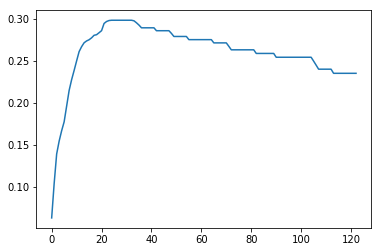

In [9]:
plt.plot(adjRs)

**Create plot of probabilities associated with the F statistic**

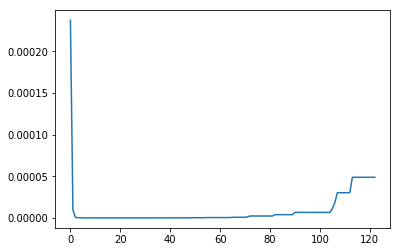

In [10]:
plt.plot(f_pvalues)

**Print adjusted R and F stat probabilities in order**

In [11]:


for c in dictionary:
    #print(str(dictionary.keys().index(c))+"{country}: {capital}".format(country=c, capital=dictionary[c])+"\n")
        print(str(list(dictionary.keys()).index(c))+ " {key} \n Adjusted R: {adjR}  Fstat(prob): {f_pvalue}".format(key=c, adjR=dictionary[c][0], f_pvalue = dictionary[c][1])+"\n")
        OLS = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + c, test_train_df[train_yrs_tt]).fit()



0 CMtn_Dewpoint_degC 
 Adjusted R: 0.06294191382646264  Fstat(prob): 0.00023735733638146402

1 KGJT_d700_500_drct+ CMtn_Dewpoint_degC 
 Adjusted R: 0.10399274369318023  Fstat(prob): 9.769187737424579e-06

2 KGJT_250mb_speed_kts+ KGJT_d700_500_drct+ CMtn_Dewpoint_degC 
 Adjusted R: 0.1391660213340109  Fstat(prob): 6.112146802590693e-07

3 KGJT_d300_250_drct+ KGJT_250mb_speed_kts+ KGJT_d700_500_drct+ CMtn_Dewpoint_degC 
 Adjusted R: 0.1545602455207672  Fstat(prob): 2.83342035016865e-07

4 CMtn_WindDirection_deg+ KGJT_d300_250_drct+ KGJT_250mb_speed_kts+ KGJT_d700_500_drct+ CMtn_Dewpoint_degC 
 Adjusted R: 0.16693236628960606  Fstat(prob): 1.6687718541445516e-07

5 KGJT_d250_200_tmpc+ CMtn_WindDirection_deg+ KGJT_d300_250_drct+ KGJT_250mb_speed_kts+ KGJT_d700_500_drct+ CMtn_Dewpoint_degC 
 Adjusted R: 0.17753489584737714  Fstat(prob): 1.1173917245752594e-07

6 KGJT_d700_400_tmpc+ KGJT_d250_200_tmpc+ CMtn_WindDirection_deg+ KGJT_d300_250_drct+ KGJT_250mb_speed_kts+ KGJT_d700_500_drct+ CMtn

25 KGJT_d700_250_drct+ KGJT_d500_200_speed_kts+ LXV_WindSpeed_mps+ KGJT_d500_250_height_m+ KGJT_200mb_height_m+ LXV_Pressure_hp+ KGJT_300mb_dwpc+ KGJT_d700_400_height_m+ KGJT_500mb_tmpc+ KGJT_d300_250_tmpc+ KGJT_d850_200_height_m+ KGJT_d400_300_height_m+ KGJT_d700_250_dwpc+ LXV_WindDirection_deg+ KGJT_d500_250_drct+ KGJT_300mb_speed_kts+ KGJT_d250_200_dwpc+ KGJT_d700_400_speed_kts+ CMtnSNTL_Temp_degC+ KGJT_d700_400_tmpc+ KGJT_d250_200_tmpc+ CMtn_WindDirection_deg+ KGJT_d300_250_drct+ KGJT_250mb_speed_kts+ KGJT_d700_500_drct+ CMtn_Dewpoint_degC 
 Adjusted R: 0.29867791027816437  Fstat(prob): 4.766839697229667e-09

26 KGJT_d500_300_drct+ KGJT_d700_250_drct+ KGJT_d500_200_speed_kts+ LXV_WindSpeed_mps+ KGJT_d500_250_height_m+ KGJT_200mb_height_m+ LXV_Pressure_hp+ KGJT_300mb_dwpc+ KGJT_d700_400_height_m+ KGJT_500mb_tmpc+ KGJT_d300_250_tmpc+ KGJT_d850_200_height_m+ KGJT_d400_300_height_m+ KGJT_d700_250_dwpc+ LXV_WindDirection_deg+ KGJT_d500_250_drct+ KGJT_300mb_speed_kts+ KGJT_d250_200_dwpc+


38 KGJT_200mb_speed_kts+ KGJT_d500_250_speed_kts+ KGJT_d300_200_speed_kts+ KGJT_400mb_drct+ LXV_Temperature_degC+ KGJT_d500_400_dwpc+ KGJT_d300_200_tmpc+ KGJT_d700_200_dwpc+ KGJT_d300_250_speed_kts+ KGJT_850mb_height_m+ KGJT_d700_300_height_m+ KGJT_d700_300_drct+ KGJT_d500_300_drct+ KGJT_d700_250_drct+ KGJT_d500_200_speed_kts+ LXV_WindSpeed_mps+ KGJT_d500_250_height_m+ KGJT_200mb_height_m+ LXV_Pressure_hp+ KGJT_300mb_dwpc+ KGJT_d700_400_height_m+ KGJT_500mb_tmpc+ KGJT_d300_250_tmpc+ KGJT_d850_200_height_m+ KGJT_d400_300_height_m+ KGJT_d700_250_dwpc+ LXV_WindDirection_deg+ KGJT_d500_250_drct+ KGJT_300mb_speed_kts+ KGJT_d250_200_dwpc+ KGJT_d700_400_speed_kts+ CMtnSNTL_Temp_degC+ KGJT_d700_400_tmpc+ KGJT_d250_200_tmpc+ CMtn_WindDirection_deg+ KGJT_d300_250_drct+ KGJT_250mb_speed_kts+ KGJT_d700_500_drct+ CMtn_Dewpoint_degC 
 Adjusted R: 0.28965937431188027  Fstat(prob): 4.2437757477610424e-08

39 KGJT_500mb_speed_kts+ KGJT_200mb_speed_kts+ KGJT_d500_250_speed_kts+ KGJT_d300_200_speed_kts+


49 KGJT_250mb_tmpc+ LXV_12hr_delta_Pressure_hp+ KGJT_d250_200_height_m+ KGJT_d850_500_height_m+ KGJT_500mb_height_m+ KGJT_d850_250_height_m+ KGJT_d500_200_height_m+ KGJT_250mb_height_m+ KGJT_d500_300_speed_kts+ KGJT_d250_200_speed_kts+ KGJT_500mb_speed_kts+ KGJT_200mb_speed_kts+ KGJT_d500_250_speed_kts+ KGJT_d300_200_speed_kts+ KGJT_400mb_drct+ LXV_Temperature_degC+ KGJT_d500_400_dwpc+ KGJT_d300_200_tmpc+ KGJT_d700_200_dwpc+ KGJT_d300_250_speed_kts+ KGJT_850mb_height_m+ KGJT_d700_300_height_m+ KGJT_d700_300_drct+ KGJT_d500_300_drct+ KGJT_d700_250_drct+ KGJT_d500_200_speed_kts+ LXV_WindSpeed_mps+ KGJT_d500_250_height_m+ KGJT_200mb_height_m+ LXV_Pressure_hp+ KGJT_300mb_dwpc+ KGJT_d700_400_height_m+ KGJT_500mb_tmpc+ KGJT_d300_250_tmpc+ KGJT_d850_200_height_m+ KGJT_d400_300_height_m+ KGJT_d700_250_dwpc+ LXV_WindDirection_deg+ KGJT_d500_250_drct+ KGJT_300mb_speed_kts+ KGJT_d250_200_dwpc+ KGJT_d700_400_speed_kts+ CMtnSNTL_Temp_degC+ KGJT_d700_400_tmpc+ KGJT_d250_200_tmpc+ CMtn_WindDirection

56 KGJT_d700_500_tmpc+ KGJT_d400_300_tmpc+ KGJT_d500_300_tmpc+ KGJT_300mb_tmpc+ KGJT_d500_200_tmpc+ KGJT_200mb_tmpc+ KGJT_d500_250_tmpc+ KGJT_250mb_tmpc+ LXV_12hr_delta_Pressure_hp+ KGJT_d250_200_height_m+ KGJT_d850_500_height_m+ KGJT_500mb_height_m+ KGJT_d850_250_height_m+ KGJT_d500_200_height_m+ KGJT_250mb_height_m+ KGJT_d500_300_speed_kts+ KGJT_d250_200_speed_kts+ KGJT_500mb_speed_kts+ KGJT_200mb_speed_kts+ KGJT_d500_250_speed_kts+ KGJT_d300_200_speed_kts+ KGJT_400mb_drct+ LXV_Temperature_degC+ KGJT_d500_400_dwpc+ KGJT_d300_200_tmpc+ KGJT_d700_200_dwpc+ KGJT_d300_250_speed_kts+ KGJT_850mb_height_m+ KGJT_d700_300_height_m+ KGJT_d700_300_drct+ KGJT_d500_300_drct+ KGJT_d700_250_drct+ KGJT_d500_200_speed_kts+ LXV_WindSpeed_mps+ KGJT_d500_250_height_m+ KGJT_200mb_height_m+ LXV_Pressure_hp+ KGJT_300mb_dwpc+ KGJT_d700_400_height_m+ KGJT_500mb_tmpc+ KGJT_d300_250_tmpc+ KGJT_d850_200_height_m+ KGJT_d400_300_height_m+ KGJT_d700_250_dwpc+ LXV_WindDirection_deg+ KGJT_d500_250_drct+ KGJT_300mb_s

64 KGJT_d400_200_tmpc+ KGJT_d500_400_tmpc+ KGJT_700mb_tmpc+ KGJT_d400_250_tmpc+ KGJT_d700_250_tmpc+ KGJT_400mb_tmpc+ KGJT_d700_200_tmpc+ KGJT_d700_300_tmpc+ KGJT_d700_500_tmpc+ KGJT_d400_300_tmpc+ KGJT_d500_300_tmpc+ KGJT_300mb_tmpc+ KGJT_d500_200_tmpc+ KGJT_200mb_tmpc+ KGJT_d500_250_tmpc+ KGJT_250mb_tmpc+ LXV_12hr_delta_Pressure_hp+ KGJT_d250_200_height_m+ KGJT_d850_500_height_m+ KGJT_500mb_height_m+ KGJT_d850_250_height_m+ KGJT_d500_200_height_m+ KGJT_250mb_height_m+ KGJT_d500_300_speed_kts+ KGJT_d250_200_speed_kts+ KGJT_500mb_speed_kts+ KGJT_200mb_speed_kts+ KGJT_d500_250_speed_kts+ KGJT_d300_200_speed_kts+ KGJT_400mb_drct+ LXV_Temperature_degC+ KGJT_d500_400_dwpc+ KGJT_d300_200_tmpc+ KGJT_d700_200_dwpc+ KGJT_d300_250_speed_kts+ KGJT_850mb_height_m+ KGJT_d700_300_height_m+ KGJT_d700_300_drct+ KGJT_d500_300_drct+ KGJT_d700_250_drct+ KGJT_d500_200_speed_kts+ LXV_WindSpeed_mps+ KGJT_d500_250_height_m+ KGJT_200mb_height_m+ LXV_Pressure_hp+ KGJT_300mb_dwpc+ KGJT_d700_400_height_m+ KGJT_5

71 LXV_Dewpoint_degC+ KGJT_d300_250_dwpc+ KGJT_700mb_dwpc+ KGJT_d700_300_dwpc+ KGJT_250mb_dwpc+ KGJT_200mb_dwpc+ KGJT_d300_200_dwpc+ KGJT_d400_200_tmpc+ KGJT_d500_400_tmpc+ KGJT_700mb_tmpc+ KGJT_d400_250_tmpc+ KGJT_d700_250_tmpc+ KGJT_400mb_tmpc+ KGJT_d700_200_tmpc+ KGJT_d700_300_tmpc+ KGJT_d700_500_tmpc+ KGJT_d400_300_tmpc+ KGJT_d500_300_tmpc+ KGJT_300mb_tmpc+ KGJT_d500_200_tmpc+ KGJT_200mb_tmpc+ KGJT_d500_250_tmpc+ KGJT_250mb_tmpc+ LXV_12hr_delta_Pressure_hp+ KGJT_d250_200_height_m+ KGJT_d850_500_height_m+ KGJT_500mb_height_m+ KGJT_d850_250_height_m+ KGJT_d500_200_height_m+ KGJT_250mb_height_m+ KGJT_d500_300_speed_kts+ KGJT_d250_200_speed_kts+ KGJT_500mb_speed_kts+ KGJT_200mb_speed_kts+ KGJT_d500_250_speed_kts+ KGJT_d300_200_speed_kts+ KGJT_400mb_drct+ LXV_Temperature_degC+ KGJT_d500_400_dwpc+ KGJT_d300_200_tmpc+ KGJT_d700_200_dwpc+ KGJT_d300_250_speed_kts+ KGJT_850mb_height_m+ KGJT_d700_300_height_m+ KGJT_d700_300_drct+ KGJT_d500_300_drct+ KGJT_d700_250_drct+ KGJT_d500_200_speed_kts

77 KGJT_d500_300_dwpc+ KGJT_d400_250_dwpc+ KGJT_400mb_dwpc+ KGJT_d400_200_dwpc+ KGJT_d500_250_dwpc+ KGJT_d500_200_dwpc+ LXV_Dewpoint_degC+ KGJT_d300_250_dwpc+ KGJT_700mb_dwpc+ KGJT_d700_300_dwpc+ KGJT_250mb_dwpc+ KGJT_200mb_dwpc+ KGJT_d300_200_dwpc+ KGJT_d400_200_tmpc+ KGJT_d500_400_tmpc+ KGJT_700mb_tmpc+ KGJT_d400_250_tmpc+ KGJT_d700_250_tmpc+ KGJT_400mb_tmpc+ KGJT_d700_200_tmpc+ KGJT_d700_300_tmpc+ KGJT_d700_500_tmpc+ KGJT_d400_300_tmpc+ KGJT_d500_300_tmpc+ KGJT_300mb_tmpc+ KGJT_d500_200_tmpc+ KGJT_200mb_tmpc+ KGJT_d500_250_tmpc+ KGJT_250mb_tmpc+ LXV_12hr_delta_Pressure_hp+ KGJT_d250_200_height_m+ KGJT_d850_500_height_m+ KGJT_500mb_height_m+ KGJT_d850_250_height_m+ KGJT_d500_200_height_m+ KGJT_250mb_height_m+ KGJT_d500_300_speed_kts+ KGJT_d250_200_speed_kts+ KGJT_500mb_speed_kts+ KGJT_200mb_speed_kts+ KGJT_d500_250_speed_kts+ KGJT_d300_200_speed_kts+ KGJT_400mb_drct+ LXV_Temperature_degC+ KGJT_d500_400_dwpc+ KGJT_d300_200_tmpc+ KGJT_d700_200_dwpc+ KGJT_d300_250_speed_kts+ KGJT_850mb_


82 KGJT_500mb_drct+ KGJT_500mb_dwpc+ KGJT_d400_300_dwpc+ KGJT_d700_500_dwpc+ KGJT_d700_400_dwpc+ KGJT_d500_300_dwpc+ KGJT_d400_250_dwpc+ KGJT_400mb_dwpc+ KGJT_d400_200_dwpc+ KGJT_d500_250_dwpc+ KGJT_d500_200_dwpc+ LXV_Dewpoint_degC+ KGJT_d300_250_dwpc+ KGJT_700mb_dwpc+ KGJT_d700_300_dwpc+ KGJT_250mb_dwpc+ KGJT_200mb_dwpc+ KGJT_d300_200_dwpc+ KGJT_d400_200_tmpc+ KGJT_d500_400_tmpc+ KGJT_700mb_tmpc+ KGJT_d400_250_tmpc+ KGJT_d700_250_tmpc+ KGJT_400mb_tmpc+ KGJT_d700_200_tmpc+ KGJT_d700_300_tmpc+ KGJT_d700_500_tmpc+ KGJT_d400_300_tmpc+ KGJT_d500_300_tmpc+ KGJT_300mb_tmpc+ KGJT_d500_200_tmpc+ KGJT_200mb_tmpc+ KGJT_d500_250_tmpc+ KGJT_250mb_tmpc+ LXV_12hr_delta_Pressure_hp+ KGJT_d250_200_height_m+ KGJT_d850_500_height_m+ KGJT_500mb_height_m+ KGJT_d850_250_height_m+ KGJT_d500_200_height_m+ KGJT_250mb_height_m+ KGJT_d500_300_speed_kts+ KGJT_d250_200_speed_kts+ KGJT_500mb_speed_kts+ KGJT_200mb_speed_kts+ KGJT_d500_250_speed_kts+ KGJT_d300_200_speed_kts+ KGJT_400mb_drct+ LXV_Temperature_degC+ K

87 KGJT_d400_250_drct+ KGJT_700mb_drct+ KGJT_d400_300_drct+ KGJT_250mb_drct+ KGJT_300mb_drct+ KGJT_500mb_drct+ KGJT_500mb_dwpc+ KGJT_d400_300_dwpc+ KGJT_d700_500_dwpc+ KGJT_d700_400_dwpc+ KGJT_d500_300_dwpc+ KGJT_d400_250_dwpc+ KGJT_400mb_dwpc+ KGJT_d400_200_dwpc+ KGJT_d500_250_dwpc+ KGJT_d500_200_dwpc+ LXV_Dewpoint_degC+ KGJT_d300_250_dwpc+ KGJT_700mb_dwpc+ KGJT_d700_300_dwpc+ KGJT_250mb_dwpc+ KGJT_200mb_dwpc+ KGJT_d300_200_dwpc+ KGJT_d400_200_tmpc+ KGJT_d500_400_tmpc+ KGJT_700mb_tmpc+ KGJT_d400_250_tmpc+ KGJT_d700_250_tmpc+ KGJT_400mb_tmpc+ KGJT_d700_200_tmpc+ KGJT_d700_300_tmpc+ KGJT_d700_500_tmpc+ KGJT_d400_300_tmpc+ KGJT_d500_300_tmpc+ KGJT_300mb_tmpc+ KGJT_d500_200_tmpc+ KGJT_200mb_tmpc+ KGJT_d500_250_tmpc+ KGJT_250mb_tmpc+ LXV_12hr_delta_Pressure_hp+ KGJT_d250_200_height_m+ KGJT_d850_500_height_m+ KGJT_500mb_height_m+ KGJT_d850_250_height_m+ KGJT_d500_200_height_m+ KGJT_250mb_height_m+ KGJT_d500_300_speed_kts+ KGJT_d250_200_speed_kts+ KGJT_500mb_speed_kts+ KGJT_200mb_speed_kts+ 

92 KGJT_d850_300_height_m+ KGJT_400mb_height_m+ KGJT_300mb_height_m+ KGJT_d500_400_drct+ KGJT_d700_400_drct+ KGJT_d400_250_drct+ KGJT_700mb_drct+ KGJT_d400_300_drct+ KGJT_250mb_drct+ KGJT_300mb_drct+ KGJT_500mb_drct+ KGJT_500mb_dwpc+ KGJT_d400_300_dwpc+ KGJT_d700_500_dwpc+ KGJT_d700_400_dwpc+ KGJT_d500_300_dwpc+ KGJT_d400_250_dwpc+ KGJT_400mb_dwpc+ KGJT_d400_200_dwpc+ KGJT_d500_250_dwpc+ KGJT_d500_200_dwpc+ LXV_Dewpoint_degC+ KGJT_d300_250_dwpc+ KGJT_700mb_dwpc+ KGJT_d700_300_dwpc+ KGJT_250mb_dwpc+ KGJT_200mb_dwpc+ KGJT_d300_200_dwpc+ KGJT_d400_200_tmpc+ KGJT_d500_400_tmpc+ KGJT_700mb_tmpc+ KGJT_d400_250_tmpc+ KGJT_d700_250_tmpc+ KGJT_400mb_tmpc+ KGJT_d700_200_tmpc+ KGJT_d700_300_tmpc+ KGJT_d700_500_tmpc+ KGJT_d400_300_tmpc+ KGJT_d500_300_tmpc+ KGJT_300mb_tmpc+ KGJT_d500_200_tmpc+ KGJT_200mb_tmpc+ KGJT_d500_250_tmpc+ KGJT_250mb_tmpc+ LXV_12hr_delta_Pressure_hp+ KGJT_d250_200_height_m+ KGJT_d850_500_height_m+ KGJT_500mb_height_m+ KGJT_d850_250_height_m+ KGJT_d500_200_height_m+ KGJT_250m

97 KGJT_d850_700_height_m+ KGJT_d400_250_height_m+ KGJT_700mb_height_m+ KGJT_d500_300_height_m+ KGJT_d500_400_height_m+ KGJT_d850_300_height_m+ KGJT_400mb_height_m+ KGJT_300mb_height_m+ KGJT_d500_400_drct+ KGJT_d700_400_drct+ KGJT_d400_250_drct+ KGJT_700mb_drct+ KGJT_d400_300_drct+ KGJT_250mb_drct+ KGJT_300mb_drct+ KGJT_500mb_drct+ KGJT_500mb_dwpc+ KGJT_d400_300_dwpc+ KGJT_d700_500_dwpc+ KGJT_d700_400_dwpc+ KGJT_d500_300_dwpc+ KGJT_d400_250_dwpc+ KGJT_400mb_dwpc+ KGJT_d400_200_dwpc+ KGJT_d500_250_dwpc+ KGJT_d500_200_dwpc+ LXV_Dewpoint_degC+ KGJT_d300_250_dwpc+ KGJT_700mb_dwpc+ KGJT_d700_300_dwpc+ KGJT_250mb_dwpc+ KGJT_200mb_dwpc+ KGJT_d300_200_dwpc+ KGJT_d400_200_tmpc+ KGJT_d500_400_tmpc+ KGJT_700mb_tmpc+ KGJT_d400_250_tmpc+ KGJT_d700_250_tmpc+ KGJT_400mb_tmpc+ KGJT_d700_200_tmpc+ KGJT_d700_300_tmpc+ KGJT_d700_500_tmpc+ KGJT_d400_300_tmpc+ KGJT_d500_300_tmpc+ KGJT_300mb_tmpc+ KGJT_d500_200_tmpc+ KGJT_200mb_tmpc+ KGJT_d500_250_tmpc+ KGJT_250mb_tmpc+ LXV_12hr_delta_Pressure_hp+ KGJT_d250

101 KGJT_d700_250_height_m+ KGJT_d300_200_height_m+ KGJT_d400_200_height_m+ KGJT_d300_250_height_m+ KGJT_d850_700_height_m+ KGJT_d400_250_height_m+ KGJT_700mb_height_m+ KGJT_d500_300_height_m+ KGJT_d500_400_height_m+ KGJT_d850_300_height_m+ KGJT_400mb_height_m+ KGJT_300mb_height_m+ KGJT_d500_400_drct+ KGJT_d700_400_drct+ KGJT_d400_250_drct+ KGJT_700mb_drct+ KGJT_d400_300_drct+ KGJT_250mb_drct+ KGJT_300mb_drct+ KGJT_500mb_drct+ KGJT_500mb_dwpc+ KGJT_d400_300_dwpc+ KGJT_d700_500_dwpc+ KGJT_d700_400_dwpc+ KGJT_d500_300_dwpc+ KGJT_d400_250_dwpc+ KGJT_400mb_dwpc+ KGJT_d400_200_dwpc+ KGJT_d500_250_dwpc+ KGJT_d500_200_dwpc+ LXV_Dewpoint_degC+ KGJT_d300_250_dwpc+ KGJT_700mb_dwpc+ KGJT_d700_300_dwpc+ KGJT_250mb_dwpc+ KGJT_200mb_dwpc+ KGJT_d300_200_dwpc+ KGJT_d400_200_tmpc+ KGJT_d500_400_tmpc+ KGJT_700mb_tmpc+ KGJT_d400_250_tmpc+ KGJT_d700_250_tmpc+ KGJT_400mb_tmpc+ KGJT_d700_200_tmpc+ KGJT_d700_300_tmpc+ KGJT_d700_500_tmpc+ KGJT_d400_300_tmpc+ KGJT_d500_300_tmpc+ KGJT_300mb_tmpc+ KGJT_d500_200_

105 CMtn_WindSpeed_mps+ KGJT_d850_400_height_m+ KGJT_d700_500_height_m+ KGJT_d700_200_height_m+ KGJT_d700_250_height_m+ KGJT_d300_200_height_m+ KGJT_d400_200_height_m+ KGJT_d300_250_height_m+ KGJT_d850_700_height_m+ KGJT_d400_250_height_m+ KGJT_700mb_height_m+ KGJT_d500_300_height_m+ KGJT_d500_400_height_m+ KGJT_d850_300_height_m+ KGJT_400mb_height_m+ KGJT_300mb_height_m+ KGJT_d500_400_drct+ KGJT_d700_400_drct+ KGJT_d400_250_drct+ KGJT_700mb_drct+ KGJT_d400_300_drct+ KGJT_250mb_drct+ KGJT_300mb_drct+ KGJT_500mb_drct+ KGJT_500mb_dwpc+ KGJT_d400_300_dwpc+ KGJT_d700_500_dwpc+ KGJT_d700_400_dwpc+ KGJT_d500_300_dwpc+ KGJT_d400_250_dwpc+ KGJT_400mb_dwpc+ KGJT_d400_200_dwpc+ KGJT_d500_250_dwpc+ KGJT_d500_200_dwpc+ LXV_Dewpoint_degC+ KGJT_d300_250_dwpc+ KGJT_700mb_dwpc+ KGJT_d700_300_dwpc+ KGJT_250mb_dwpc+ KGJT_200mb_dwpc+ KGJT_d300_200_dwpc+ KGJT_d400_200_tmpc+ KGJT_d500_400_tmpc+ KGJT_700mb_tmpc+ KGJT_d400_250_tmpc+ KGJT_d700_250_tmpc+ KGJT_400mb_tmpc+ KGJT_d700_200_tmpc+ KGJT_d700_300_tmpc+

109 KGJT_d500_200_drct+ KGJT_d250_200_drct+ KGJT_d300_200_drct+ CMtn_Temperature_degC+ CMtn_WindSpeed_mps+ KGJT_d850_400_height_m+ KGJT_d700_500_height_m+ KGJT_d700_200_height_m+ KGJT_d700_250_height_m+ KGJT_d300_200_height_m+ KGJT_d400_200_height_m+ KGJT_d300_250_height_m+ KGJT_d850_700_height_m+ KGJT_d400_250_height_m+ KGJT_700mb_height_m+ KGJT_d500_300_height_m+ KGJT_d500_400_height_m+ KGJT_d850_300_height_m+ KGJT_400mb_height_m+ KGJT_300mb_height_m+ KGJT_d500_400_drct+ KGJT_d700_400_drct+ KGJT_d400_250_drct+ KGJT_700mb_drct+ KGJT_d400_300_drct+ KGJT_250mb_drct+ KGJT_300mb_drct+ KGJT_500mb_drct+ KGJT_500mb_dwpc+ KGJT_d400_300_dwpc+ KGJT_d700_500_dwpc+ KGJT_d700_400_dwpc+ KGJT_d500_300_dwpc+ KGJT_d400_250_dwpc+ KGJT_400mb_dwpc+ KGJT_d400_200_dwpc+ KGJT_d500_250_dwpc+ KGJT_d500_200_dwpc+ LXV_Dewpoint_degC+ KGJT_d300_250_dwpc+ KGJT_700mb_dwpc+ KGJT_d700_300_dwpc+ KGJT_250mb_dwpc+ KGJT_200mb_dwpc+ KGJT_d300_200_dwpc+ KGJT_d400_200_tmpc+ KGJT_d500_400_tmpc+ KGJT_700mb_tmpc+ KGJT_d400_250

113 KGJT_d400_250_speed_kts+ KGJT_d400_200_drct+ KGJT_200mb_drct+ KGJT_d700_200_drct+ KGJT_d500_200_drct+ KGJT_d250_200_drct+ KGJT_d300_200_drct+ CMtn_Temperature_degC+ CMtn_WindSpeed_mps+ KGJT_d850_400_height_m+ KGJT_d700_500_height_m+ KGJT_d700_200_height_m+ KGJT_d700_250_height_m+ KGJT_d300_200_height_m+ KGJT_d400_200_height_m+ KGJT_d300_250_height_m+ KGJT_d850_700_height_m+ KGJT_d400_250_height_m+ KGJT_700mb_height_m+ KGJT_d500_300_height_m+ KGJT_d500_400_height_m+ KGJT_d850_300_height_m+ KGJT_400mb_height_m+ KGJT_300mb_height_m+ KGJT_d500_400_drct+ KGJT_d700_400_drct+ KGJT_d400_250_drct+ KGJT_700mb_drct+ KGJT_d400_300_drct+ KGJT_250mb_drct+ KGJT_300mb_drct+ KGJT_500mb_drct+ KGJT_500mb_dwpc+ KGJT_d400_300_dwpc+ KGJT_d700_500_dwpc+ KGJT_d700_400_dwpc+ KGJT_d500_300_dwpc+ KGJT_d400_250_dwpc+ KGJT_400mb_dwpc+ KGJT_d400_200_dwpc+ KGJT_d500_250_dwpc+ KGJT_d500_200_dwpc+ LXV_Dewpoint_degC+ KGJT_d300_250_dwpc+ KGJT_700mb_dwpc+ KGJT_d700_300_dwpc+ KGJT_250mb_dwpc+ KGJT_200mb_dwpc+ KGJT_d30

117 KGJT_d700_500_speed_kts+ KGJT_700mb_speed_kts+ KGJT_d700_300_speed_kts+ KGJT_d700_200_speed_kts+ KGJT_d400_250_speed_kts+ KGJT_d400_200_drct+ KGJT_200mb_drct+ KGJT_d700_200_drct+ KGJT_d500_200_drct+ KGJT_d250_200_drct+ KGJT_d300_200_drct+ CMtn_Temperature_degC+ CMtn_WindSpeed_mps+ KGJT_d850_400_height_m+ KGJT_d700_500_height_m+ KGJT_d700_200_height_m+ KGJT_d700_250_height_m+ KGJT_d300_200_height_m+ KGJT_d400_200_height_m+ KGJT_d300_250_height_m+ KGJT_d850_700_height_m+ KGJT_d400_250_height_m+ KGJT_700mb_height_m+ KGJT_d500_300_height_m+ KGJT_d500_400_height_m+ KGJT_d850_300_height_m+ KGJT_400mb_height_m+ KGJT_300mb_height_m+ KGJT_d500_400_drct+ KGJT_d700_400_drct+ KGJT_d400_250_drct+ KGJT_700mb_drct+ KGJT_d400_300_drct+ KGJT_250mb_drct+ KGJT_300mb_drct+ KGJT_500mb_drct+ KGJT_500mb_dwpc+ KGJT_d400_300_dwpc+ KGJT_d700_500_dwpc+ KGJT_d700_400_dwpc+ KGJT_d500_300_dwpc+ KGJT_d400_250_dwpc+ KGJT_400mb_dwpc+ KGJT_d400_200_dwpc+ KGJT_d500_250_dwpc+ KGJT_d500_200_dwpc+ LXV_Dewpoint_degC+ KG

121 KGJT_400mb_speed_kts+ KGJT_d400_300_speed_kts+ KGJT_d700_250_speed_kts+ KGJT_d500_400_speed_kts+ KGJT_d700_500_speed_kts+ KGJT_700mb_speed_kts+ KGJT_d700_300_speed_kts+ KGJT_d700_200_speed_kts+ KGJT_d400_250_speed_kts+ KGJT_d400_200_drct+ KGJT_200mb_drct+ KGJT_d700_200_drct+ KGJT_d500_200_drct+ KGJT_d250_200_drct+ KGJT_d300_200_drct+ CMtn_Temperature_degC+ CMtn_WindSpeed_mps+ KGJT_d850_400_height_m+ KGJT_d700_500_height_m+ KGJT_d700_200_height_m+ KGJT_d700_250_height_m+ KGJT_d300_200_height_m+ KGJT_d400_200_height_m+ KGJT_d300_250_height_m+ KGJT_d850_700_height_m+ KGJT_d400_250_height_m+ KGJT_700mb_height_m+ KGJT_d500_300_height_m+ KGJT_d500_400_height_m+ KGJT_d850_300_height_m+ KGJT_400mb_height_m+ KGJT_300mb_height_m+ KGJT_d500_400_drct+ KGJT_d700_400_drct+ KGJT_d400_250_drct+ KGJT_700mb_drct+ KGJT_d400_300_drct+ KGJT_250mb_drct+ KGJT_300mb_drct+ KGJT_500mb_drct+ KGJT_500mb_dwpc+ KGJT_d400_300_dwpc+ KGJT_d700_500_dwpc+ KGJT_d700_400_dwpc+ KGJT_d500_300_dwpc+ KGJT_d400_250_dwpc+ K

**Find max adj R and obtain OLS summary**

In [12]:
 # Just use 'min' instead of 'max' for minimum.
print("Print maximum:")
maximum = max(dictionary, key=dictionary.get) 
print(maximum)

Print maximum:
KGJT_850mb_height_m+ KGJT_d700_300_height_m+ KGJT_d700_300_drct+ KGJT_d500_300_drct+ KGJT_d700_250_drct+ KGJT_d500_200_speed_kts+ LXV_WindSpeed_mps+ KGJT_d500_250_height_m+ KGJT_200mb_height_m+ LXV_Pressure_hp+ KGJT_300mb_dwpc+ KGJT_d700_400_height_m+ KGJT_500mb_tmpc+ KGJT_d300_250_tmpc+ KGJT_d850_200_height_m+ KGJT_d400_300_height_m+ KGJT_d700_250_dwpc+ LXV_WindDirection_deg+ KGJT_d500_250_drct+ KGJT_300mb_speed_kts+ KGJT_d250_200_dwpc+ KGJT_d700_400_speed_kts+ CMtnSNTL_Temp_degC+ KGJT_d700_400_tmpc+ KGJT_d250_200_tmpc+ CMtn_WindDirection_deg+ KGJT_d300_250_drct+ KGJT_250mb_speed_kts+ KGJT_d700_500_drct+ CMtn_Dewpoint_degC


In [13]:
maximum_all_str = max(dictionary, key=dictionary.get) 
print(maximum_all_str)

maxOLS_all = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + maximum_all_str , test_train_df[train_yrs_tt]).fit() 
print(maxOLS_all.summary())


KGJT_850mb_height_m+ KGJT_d700_300_height_m+ KGJT_d700_300_drct+ KGJT_d500_300_drct+ KGJT_d700_250_drct+ KGJT_d500_200_speed_kts+ LXV_WindSpeed_mps+ KGJT_d500_250_height_m+ KGJT_200mb_height_m+ LXV_Pressure_hp+ KGJT_300mb_dwpc+ KGJT_d700_400_height_m+ KGJT_500mb_tmpc+ KGJT_d300_250_tmpc+ KGJT_d850_200_height_m+ KGJT_d400_300_height_m+ KGJT_d700_250_dwpc+ LXV_WindDirection_deg+ KGJT_d500_250_drct+ KGJT_300mb_speed_kts+ KGJT_d250_200_dwpc+ KGJT_d700_400_speed_kts+ CMtnSNTL_Temp_degC+ KGJT_d700_400_tmpc+ KGJT_d250_200_tmpc+ CMtn_WindDirection_deg+ KGJT_d300_250_drct+ KGJT_250mb_speed_kts+ KGJT_d700_500_drct+ CMtn_Dewpoint_degC
                                      OLS Regression Results                                     
Dep. Variable:     CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in   R-squared:                       0.389
Model:                                               OLS   Adj. R-squared:                  0.299
Method:                                    Least Squares   F-statistic:   

**There are a few variables with P|t| values which are high, indicative of high randomness. Let's test different P|t| thresholds for which to remove variables, rerun and model for each set of variables, and see what threshold might glean best results**

In [14]:
rsq_adj = 0
thresh = 0

goodp_str = ""
highp_var = []

maximum_all_str = max(dictionary, key=dictionary.get)    #this is the string of variables found in previous OLS run associated with mad adjusted R squared.
print(maximum_all_str)


for test_thresh in range(1, 100):   #loop through different P|t| thresholds ranging from 1 to 100.  Note floats are not allowed here 
  print(test_thresh)
  highp_var = [var for var in maxOLS_all.pvalues.keys() if maxOLS_all.pvalues[var]>=test_thresh*0.01]  #check P|t| for each variable against threshold and store in list
  
  testgoodp_str = maximum_all_str   #reset testgoodp_str 
    
  for var in highp_var:
    testgoodp_str = testgoodp_str.replace("+ " + var, "")   #  
     

 

  maxOLS_testgoodp = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + testgoodp_str,test_train_df[train_yrs_tt]).fit()
  print(testgoodp_str, maxOLS_testgoodp.rsquared_adj, test_thresh*0.01)
  #print(maxOLS_testgoodp.rsquared_adj)
  if maxOLS_testgoodp.rsquared_adj > rsq_adj:
      rsq_adj = maxOLS_testgoodp.rsquared_adj
      print(maxOLS_testgoodp.rsquared_adj, test_thresh*0.01)
      goodp_str = testgoodp_str
      thresh = test_thresh*0.01

    
print("\n best threshold is:" + str(thresh))
maxOLS_goodp = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + goodp_str,test_train_df[train_yrs_tt]).fit() 
print(maxOLS_goodp.summary())


KGJT_850mb_height_m+ KGJT_d700_300_height_m+ KGJT_d700_300_drct+ KGJT_d500_300_drct+ KGJT_d700_250_drct+ KGJT_d500_200_speed_kts+ LXV_WindSpeed_mps+ KGJT_d500_250_height_m+ KGJT_200mb_height_m+ LXV_Pressure_hp+ KGJT_300mb_dwpc+ KGJT_d700_400_height_m+ KGJT_500mb_tmpc+ KGJT_d300_250_tmpc+ KGJT_d850_200_height_m+ KGJT_d400_300_height_m+ KGJT_d700_250_dwpc+ LXV_WindDirection_deg+ KGJT_d500_250_drct+ KGJT_300mb_speed_kts+ KGJT_d250_200_dwpc+ KGJT_d700_400_speed_kts+ CMtnSNTL_Temp_degC+ KGJT_d700_400_tmpc+ KGJT_d250_200_tmpc+ CMtn_WindDirection_deg+ KGJT_d300_250_drct+ KGJT_250mb_speed_kts+ KGJT_d700_500_drct+ CMtn_Dewpoint_degC
1
KGJT_850mb_height_m+ KGJT_d700_300_drct+ KGJT_d500_250_drct+ KGJT_d700_400_tmpc+ CMtn_WindDirection_deg+ KGJT_d300_250_drct+ KGJT_d700_500_drct+ CMtn_Dewpoint_degC 0.16238816717938798 0.01
0.16238816717938798 0.01
2
KGJT_850mb_height_m+ KGJT_d700_300_drct+ KGJT_200mb_height_m+ LXV_Pressure_hp+ KGJT_d500_250_drct+ KGJT_300mb_speed_kts+ KGJT_d700_400_speed_kts+ KGJT

KGJT_850mb_height_m+ KGJT_d700_300_drct+ KGJT_d700_250_drct+ LXV_WindSpeed_mps+ KGJT_d500_250_height_m+ KGJT_200mb_height_m+ LXV_Pressure_hp+ KGJT_300mb_dwpc+ KGJT_d700_400_height_m+ KGJT_500mb_tmpc+ KGJT_d300_250_tmpc+ KGJT_d400_300_height_m+ KGJT_d700_250_dwpc+ KGJT_d500_250_drct+ KGJT_300mb_speed_kts+ KGJT_d250_200_dwpc+ KGJT_d700_400_speed_kts+ CMtnSNTL_Temp_degC+ KGJT_d700_400_tmpc+ CMtn_WindDirection_deg+ KGJT_d300_250_drct+ KGJT_d700_500_drct+ CMtn_Dewpoint_degC 0.3001989148249956 0.22
23
KGJT_850mb_height_m+ KGJT_d700_300_drct+ KGJT_d700_250_drct+ LXV_WindSpeed_mps+ KGJT_d500_250_height_m+ KGJT_200mb_height_m+ LXV_Pressure_hp+ KGJT_300mb_dwpc+ KGJT_d700_400_height_m+ KGJT_500mb_tmpc+ KGJT_d300_250_tmpc+ KGJT_d400_300_height_m+ KGJT_d700_250_dwpc+ KGJT_d500_250_drct+ KGJT_300mb_speed_kts+ KGJT_d250_200_dwpc+ KGJT_d700_400_speed_kts+ CMtnSNTL_Temp_degC+ KGJT_d700_400_tmpc+ CMtn_WindDirection_deg+ KGJT_d300_250_drct+ KGJT_d700_500_drct+ CMtn_Dewpoint_degC 0.3001989148249956 0.23
2

KGJT_850mb_height_m+ KGJT_d700_300_drct+ KGJT_d700_250_drct+ KGJT_d500_200_speed_kts+ LXV_WindSpeed_mps+ KGJT_d500_250_height_m+ KGJT_200mb_height_m+ LXV_Pressure_hp+ KGJT_300mb_dwpc+ KGJT_d700_400_height_m+ KGJT_500mb_tmpc+ KGJT_d300_250_tmpc+ KGJT_d850_200_height_m+ KGJT_d400_300_height_m+ KGJT_d700_250_dwpc+ LXV_WindDirection_deg+ KGJT_d500_250_drct+ KGJT_300mb_speed_kts+ KGJT_d250_200_dwpc+ KGJT_d700_400_speed_kts+ CMtnSNTL_Temp_degC+ KGJT_d700_400_tmpc+ KGJT_d250_200_tmpc+ CMtn_WindDirection_deg+ KGJT_d300_250_drct+ KGJT_d700_500_drct+ CMtn_Dewpoint_degC 0.3028009902833605 0.37
38
KGJT_850mb_height_m+ KGJT_d700_300_drct+ KGJT_d700_250_drct+ KGJT_d500_200_speed_kts+ LXV_WindSpeed_mps+ KGJT_d500_250_height_m+ KGJT_200mb_height_m+ LXV_Pressure_hp+ KGJT_300mb_dwpc+ KGJT_d700_400_height_m+ KGJT_500mb_tmpc+ KGJT_d300_250_tmpc+ KGJT_d850_200_height_m+ KGJT_d400_300_height_m+ KGJT_d700_250_dwpc+ LXV_WindDirection_deg+ KGJT_d500_250_drct+ KGJT_300mb_speed_kts+ KGJT_d250_200_dwpc+ KGJT_d700

KGJT_850mb_height_m+ KGJT_d700_300_height_m+ KGJT_d700_300_drct+ KGJT_d700_250_drct+ KGJT_d500_200_speed_kts+ LXV_WindSpeed_mps+ KGJT_d500_250_height_m+ KGJT_200mb_height_m+ LXV_Pressure_hp+ KGJT_300mb_dwpc+ KGJT_d700_400_height_m+ KGJT_500mb_tmpc+ KGJT_d300_250_tmpc+ KGJT_d850_200_height_m+ KGJT_d400_300_height_m+ KGJT_d700_250_dwpc+ LXV_WindDirection_deg+ KGJT_d500_250_drct+ KGJT_300mb_speed_kts+ KGJT_d250_200_dwpc+ KGJT_d700_400_speed_kts+ CMtnSNTL_Temp_degC+ KGJT_d700_400_tmpc+ KGJT_d250_200_tmpc+ CMtn_WindDirection_deg+ KGJT_d300_250_drct+ KGJT_d700_500_drct+ CMtn_Dewpoint_degC 0.30280099028336005 0.52
53
KGJT_850mb_height_m+ KGJT_d700_300_height_m+ KGJT_d700_300_drct+ KGJT_d500_300_drct+ KGJT_d700_250_drct+ KGJT_d500_200_speed_kts+ LXV_WindSpeed_mps+ KGJT_d500_250_height_m+ KGJT_200mb_height_m+ LXV_Pressure_hp+ KGJT_300mb_dwpc+ KGJT_d700_400_height_m+ KGJT_500mb_tmpc+ KGJT_d300_250_tmpc+ KGJT_d850_200_height_m+ KGJT_d400_300_height_m+ KGJT_d700_250_dwpc+ LXV_WindDirection_deg+ KG

KGJT_850mb_height_m+ KGJT_d700_300_height_m+ KGJT_d700_300_drct+ KGJT_d500_300_drct+ KGJT_d700_250_drct+ KGJT_d500_200_speed_kts+ LXV_WindSpeed_mps+ KGJT_d500_250_height_m+ KGJT_200mb_height_m+ LXV_Pressure_hp+ KGJT_300mb_dwpc+ KGJT_d700_400_height_m+ KGJT_500mb_tmpc+ KGJT_d300_250_tmpc+ KGJT_d850_200_height_m+ KGJT_d400_300_height_m+ KGJT_d700_250_dwpc+ LXV_WindDirection_deg+ KGJT_d500_250_drct+ KGJT_300mb_speed_kts+ KGJT_d250_200_dwpc+ KGJT_d700_400_speed_kts+ CMtnSNTL_Temp_degC+ KGJT_d700_400_tmpc+ KGJT_d250_200_tmpc+ CMtn_WindDirection_deg+ KGJT_d300_250_drct+ KGJT_d700_500_drct+ CMtn_Dewpoint_degC 0.30280099028335916 0.67
68
KGJT_850mb_height_m+ KGJT_d700_300_height_m+ KGJT_d700_300_drct+ KGJT_d500_300_drct+ KGJT_d700_250_drct+ KGJT_d500_200_speed_kts+ LXV_WindSpeed_mps+ KGJT_d500_250_height_m+ KGJT_200mb_height_m+ LXV_Pressure_hp+ KGJT_300mb_dwpc+ KGJT_d700_400_height_m+ KGJT_500mb_tmpc+ KGJT_d300_250_tmpc+ KGJT_d850_200_height_m+ KGJT_d400_300_height_m+ KGJT_d700_250_dwpc+ LXV_W

KGJT_850mb_height_m+ KGJT_d700_300_height_m+ KGJT_d700_300_drct+ KGJT_d500_300_drct+ KGJT_d700_250_drct+ KGJT_d500_200_speed_kts+ LXV_WindSpeed_mps+ KGJT_d500_250_height_m+ KGJT_200mb_height_m+ LXV_Pressure_hp+ KGJT_300mb_dwpc+ KGJT_d700_400_height_m+ KGJT_500mb_tmpc+ KGJT_d300_250_tmpc+ KGJT_d850_200_height_m+ KGJT_d400_300_height_m+ KGJT_d700_250_dwpc+ LXV_WindDirection_deg+ KGJT_d500_250_drct+ KGJT_300mb_speed_kts+ KGJT_d250_200_dwpc+ KGJT_d700_400_speed_kts+ CMtnSNTL_Temp_degC+ KGJT_d700_400_tmpc+ KGJT_d250_200_tmpc+ CMtn_WindDirection_deg+ KGJT_d300_250_drct+ KGJT_d700_500_drct+ CMtn_Dewpoint_degC 0.30280099028335916 0.81
82
KGJT_850mb_height_m+ KGJT_d700_300_height_m+ KGJT_d700_300_drct+ KGJT_d500_300_drct+ KGJT_d700_250_drct+ KGJT_d500_200_speed_kts+ LXV_WindSpeed_mps+ KGJT_d500_250_height_m+ KGJT_200mb_height_m+ LXV_Pressure_hp+ KGJT_300mb_dwpc+ KGJT_d700_400_height_m+ KGJT_500mb_tmpc+ KGJT_d300_250_tmpc+ KGJT_d850_200_height_m+ KGJT_d400_300_height_m+ KGJT_d700_250_dwpc+ LXV_W

KGJT_850mb_height_m+ KGJT_d700_300_height_m+ KGJT_d700_300_drct+ KGJT_d500_300_drct+ KGJT_d700_250_drct+ KGJT_d500_200_speed_kts+ LXV_WindSpeed_mps+ KGJT_d500_250_height_m+ KGJT_200mb_height_m+ LXV_Pressure_hp+ KGJT_300mb_dwpc+ KGJT_d700_400_height_m+ KGJT_500mb_tmpc+ KGJT_d300_250_tmpc+ KGJT_d850_200_height_m+ KGJT_d400_300_height_m+ KGJT_d700_250_dwpc+ LXV_WindDirection_deg+ KGJT_d500_250_drct+ KGJT_300mb_speed_kts+ KGJT_d250_200_dwpc+ KGJT_d700_400_speed_kts+ CMtnSNTL_Temp_degC+ KGJT_d700_400_tmpc+ KGJT_d250_200_tmpc+ CMtn_WindDirection_deg+ KGJT_d300_250_drct+ KGJT_d700_500_drct+ CMtn_Dewpoint_degC 0.30280099028335916 0.96
97
KGJT_850mb_height_m+ KGJT_d700_300_height_m+ KGJT_d700_300_drct+ KGJT_d500_300_drct+ KGJT_d700_250_drct+ KGJT_d500_200_speed_kts+ LXV_WindSpeed_mps+ KGJT_d500_250_height_m+ KGJT_200mb_height_m+ LXV_Pressure_hp+ KGJT_300mb_dwpc+ KGJT_d700_400_height_m+ KGJT_500mb_tmpc+ KGJT_d300_250_tmpc+ KGJT_d850_200_height_m+ KGJT_d400_300_height_m+ KGJT_d700_250_dwpc+ LXV_W

In [17]:
import csv
actual_snf = test_train_df[test_yrs_tt]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][test_train_df[test_yrs_tt]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']>=3]
predict_snf = maxOLS_goodp.predict(test_train_df[test_yrs_tt][test_train_df[test_yrs_tt]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']>=3])

rows = zip(actual_snf, predict_snf)

with open('C:/Users/RAPP/Documents/Capstone/Analysis Notebooks/B0-UASFC_2014Train_OLS.csv', "w") as f:
    writer = csv.writer(f)
    for row in rows:
        writer.writerow(row)

In [29]:
def heatMap_small(df):
    #Create Correlation df
    corr = df.corr()
    #Plot figsize
    fig, ax = plt.subplots(figsize=(10, 10))
    #Generate Color Map
    colormap = sns.diverging_palette(220, 10, as_cmap=True)
    #Generate Heat Map, allow annotations and place floats in map
    sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f")
    #Apply xticks
    plt.xticks(range(len(corr.columns)), corr.columns)
    #ax.set_xticklabels(['KGJT_d700_250_drct', 'LXV_Temperature_degC', 'LXV_WindSpeed_mps', 'KGJT_400mb_drct', 'KGJT_d300_200_dwpc',
    #'KGJT_d700_400_tmpc', 'KGJT_d250_200_dwpc', 'KGJT_700mb_speed_kts', 'KGJT_500mb_drct', 'KGJT_d250_200_tmpc', 
    #'KGJT_d300_250_drct', 'CMtn_WindDirection_deg', 'KGJT_d250_200_speed_kts', 'KGJT_250mb_drct', 'KGJT_400mb_dwpc', 
    #'KGJT_d700_500_drct', 'CMtn_Dewpoint_degC'])
    print(corr.columns)
    #Apply yticks
    plt.yticks(range(len(corr.columns)), corr.columns)
    #show plot
    plt.show()
    
def heatMap_large(df):
    #Create Correlation df
    corr = df.corr()
    #Plot figsize
    fig, ax = plt.subplots(figsize=(50, 50))
    #Generate Color Map
    colormap = sns.diverging_palette(220, 10, as_cmap=True)
    #Generate Heat Map, allow annotations and place floats in map
    sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f")
    #Apply xticks
    plt.xticks(range(len(corr.columns)), corr.columns);
    #Apply yticks
    plt.yticks(range(len(corr.columns)), corr.columns)
    #show plot
    plt.show()

In [15]:
#print(test_train_df[train_yrs].loc[:, ['LXV_12hr_delta_Pressure_hp', 'CMtn_WindDirection_deg',  'CMtn_WindSpeed_mps', 'CMtn_Dewpoint_degC']])
heatMap_small(asos_snotel_UA_df[train_yrs].loc[:, ['KGJT_d700_250_drct', 'LXV_Temperature_degC', 'LXV_WindSpeed_mps', 'KGJT_400mb_drct', 'KGJT_d300_200_dwpc', \
'KGJT_d700_400_tmpc', 'KGJT_d250_200_dwpc', 'KGJT_700mb_speed_kts', 'KGJT_500mb_drct', 'KGJT_d250_200_tmpc',  \
'KGJT_d300_250_drct', 'CMtn_WindDirection_deg', 'KGJT_d250_200_speed_kts', 'KGJT_250mb_drct', 'KGJT_400mb_dwpc', \
'KGJT_d700_500_drct', 'CMtn_Dewpoint_degC']])

NameError: name 'heatMap_small' is not defined

**No improvement to P|t| could be made**